<a href="https://colab.research.google.com/github/pathikritsyam/ECTA/blob/main/ANN/ANN_%26_GA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import tensorflow as tf
# Solo configurar GPU si está disponible
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print(f"GPU disponible: {physical_devices[0]}")
else:
    print("No hay GPU disponible. Usando CPU.")

No hay GPU disponible. Usando CPU.


# 04.02 - Exploratory Data Analysis & ANN & Genetic Algorithm - Full Notebook

## Imports & setup

In [53]:
import pathlib
import datetime
from os import PathLike
from typing import Union

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import palettable
import seaborn as sns
%matplotlib inline

PROJECT_DIR = pathlib.Path.cwd().parent.resolve()
CLEAN_DATA_DIR = PROJECT_DIR / 'data' / '05-clean'

plt.style.use('grayscale')
# Custom Overrides to grayscale
params = {'legend.fontsize': 'x-large',
          'lines.linewidth': 0.75,
      'figure.figsize': (15, 7),
          'grid.color': 'white',
          'axes.axisbelow': False,
          'axes.grid': True,
          'axes.grid.axis': 'y',
     'axes.labelsize': 'x-large',
     'axes.titlesize':'xx-large',
     'xtick.labelsize':'x-large',
     'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
figsize=(15,7)

## Load Data

In [54]:
dtypes = {'Temperature': np.float64, 'Dewpoint Temp':np.float64, 'Relative Humidity':np.float64,
          'Wind Speed': np.float64, 'Visibility': np.float64, 'Pressure': np.float64,
          'Wind_Chill': np.float64,
         'Hour_of_Day': np.float64, 'Year': np.float64, 'Month': np.float64,
         'Day_Of_Week': np.float64, 'Day_of_Year': np.float64, 'Week_Of_Year': np.float64,
          'Quarter': np.float64, 'Stat_Hol': np.float64}


df_orig = pd.read_excel("../data/ECTA 2023 Dataset.xlsx")

# Convert Date column to datetime with dayfirst=True and handle errors
df_orig['Date'] = pd.to_datetime(df_orig['Date'], dayfirst=True, errors='coerce')

# Drop rows with invalid dates (NaT)
df_orig = df_orig.dropna(subset=['Date'])

# Set Date as index
df_orig.set_index('Date', inplace=True)

# Apply dtypes to relevant columns
for col, dtype in dtypes.items():
    if col in df_orig.columns:
        df_orig[col] = df_orig[col].astype(dtype)

daymapper = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
weekdaymapper = {0: 'Weekday', 1: 'Weekday', 2: 'Weekday', 3: 'Weekday', 4: 'Weekday',
                 5: 'Weekend', 6: 'Weekend'}
df_orig['dayofweek'] = df_orig['Day_Of_Week'].map(daymapper)
df_orig['daytype'] = df_orig['Day_Of_Week'].map(weekdaymapper)

print(f"Dataset loaded successfully. Shape: {df_orig.shape}")

Dataset loaded successfully. Shape: (96360, 18)


In [55]:
df_orig.head()

,Time,Year,Quarter,Month,Week_Of_Year,Day_of_Year,Day_Of_Week,Stat_Hol,Hour_of_Day,Relative Humidity,Wind Speed,Visibility,Pressure,Wind_Chill,Dewpoint Temp,Temperature,dayofweek,daytype
Date,,,,,,,,,,,,,,,,,,
2010-01-01,00:00:00,2010.0,1.0,1.0,53.0,1.0,4.0,1.0,0.0,76.0,26.0,25.0,99.26,-18.0,-12.7,-9.3,Fri,Weekday
2010-01-01,01:00:00,2010.0,1.0,1.0,53.0,1.0,4.0,1.0,1.0,76.0,26.0,25.0,99.26,-18.0,-12.8,-9.3,Fri,Weekday
2010-01-01,02:00:00,2010.0,1.0,1.0,53.0,1.0,4.0,1.0,2.0,74.0,26.0,25.0,99.29,-18.0,-13.4,-9.6,Fri,Weekday
2010-01-01,03:00:00,2010.0,1.0,1.0,53.0,1.0,4.0,1.0,3.0,72.0,22.0,25.0,99.35,-18.0,-13.9,-9.8,Fri,Weekday
2010-01-01,04:00:00,2010.0,1.0,1.0,53.0,1.0,4.0,1.0,4.0,74.0,32.0,24.1,99.42,-19.0,-13.5,-9.7,Fri,Weekday


In [56]:
df_orig.tail()

,Time,Year,Quarter,Month,Week_Of_Year,Day_of_Year,Day_Of_Week,Stat_Hol,Hour_of_Day,Relative Humidity,Wind Speed,Visibility,Pressure,Wind_Chill,Dewpoint Temp,Temperature,dayofweek,daytype
Date,,,,,,,,,,,,,,,,,,
2020-12-31,19:00:00,2020.0,4.0,12.0,53.0,365.0,3.0,0.0,19.0,94.0,9.0,16.1,99.21,-11.702041,0.8,1.6,Thu,Weekday
2020-12-31,20:00:00,2020.0,4.0,12.0,53.0,365.0,3.0,0.0,20.0,95.0,9.0,11.3,99.21,-11.702041,0.4,1.1,Thu,Weekday
2020-12-31,21:00:00,2020.0,4.0,12.0,53.0,365.0,3.0,0.0,21.0,97.0,7.0,9.7,99.20,-11.702041,0.6,1.0,Thu,Weekday
2020-12-31,22:00:00,2020.0,4.0,12.0,53.0,365.0,3.0,0.0,22.0,97.0,7.0,9.7,99.20,-11.702041,0.5,0.9,Thu,Weekday
2020-12-31,23:00:00,2020.0,4.0,12.0,53.0,365.0,3.0,0.0,23.0,96.0,7.0,8.0,99.19,-11.702041,0.1,0.6,Thu,Weekday


In [57]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96360 entries, 2010-01-01 to 2020-12-31
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Time               96360 non-null  object 
 1   Year               96360 non-null  float64
 2   Quarter            96360 non-null  float64
 3   Month              96360 non-null  float64
 4   Week_Of_Year       96360 non-null  float64
 5   Day_of_Year        96360 non-null  float64
 6   Day_Of_Week        96360 non-null  float64
 7   Stat_Hol           96360 non-null  float64
 8   Hour_of_Day        96360 non-null  float64
 9   Relative Humidity  96360 non-null  float64
 10  Wind Speed         96360 non-null  float64
 11  Visibility         96360 non-null  float64
 12  Pressure           96360 non-null  float64
 13  Wind_Chill         96360 non-null  float64
 14  Dewpoint Temp      96360 non-null  float64
 15  Temperature        96360 non-null  float64
 16  dayof

In [58]:
for col in df_orig.columns:
    print(col)

Time
Year
Quarter
Month
Week_Of_Year
Day_of_Year
Day_Of_Week
Stat_Hol
Hour_of_Day
Relative Humidity
Wind Speed
Visibility
Pressure
Wind_Chill
Dewpoint Temp
Temperature
dayofweek
daytype


In [59]:
df_orig['Year'].value_counts()

Year
2010.0    8760
2011.0    8760
2012.0    8760
2013.0    8760
2014.0    8760
2015.0    8760
2016.0    8760
2017.0    8760
2018.0    8760
2019.0    8760
2020.0    8760
Name: count, dtype: int64

### Data for Every Hour in 2008

In [60]:
pd.set_option('display.max_columns', 100)

df2018 = df_orig.loc['2010':'2015', :].copy(deep=True)
df2018.head()

,Time,Year,Quarter,Month,Week_Of_Year,Day_of_Year,Day_Of_Week,Stat_Hol,Hour_of_Day,Relative Humidity,Wind Speed,Visibility,Pressure,Wind_Chill,Dewpoint Temp,Temperature,dayofweek,daytype
Date,,,,,,,,,,,,,,,,,,
2010-01-01,00:00:00,2010.0,1.0,1.0,53.0,1.0,4.0,1.0,0.0,76.0,26.0,25.0,99.26,-18.0,-12.7,-9.3,Fri,Weekday
2010-01-01,01:00:00,2010.0,1.0,1.0,53.0,1.0,4.0,1.0,1.0,76.0,26.0,25.0,99.26,-18.0,-12.8,-9.3,Fri,Weekday
2010-01-01,02:00:00,2010.0,1.0,1.0,53.0,1.0,4.0,1.0,2.0,74.0,26.0,25.0,99.29,-18.0,-13.4,-9.6,Fri,Weekday
2010-01-01,03:00:00,2010.0,1.0,1.0,53.0,1.0,4.0,1.0,3.0,72.0,22.0,25.0,99.35,-18.0,-13.9,-9.8,Fri,Weekday
2010-01-01,04:00:00,2010.0,1.0,1.0,53.0,1.0,4.0,1.0,4.0,74.0,32.0,24.1,99.42,-19.0,-13.5,-9.7,Fri,Weekday


In [61]:
df2018.describe()

,Year,Quarter,Month,Week_Of_Year,Day_of_Year,Day_Of_Week,Stat_Hol,Hour_of_Day,Relative Humidity,Wind Speed,Visibility,Pressure,Wind_Chill,Dewpoint Temp,Temperature
count,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000
mean,2012.500000,2.509589,6.526027,26.612785,183.279452,3.000000,0.027397,11.500000,69.163271,16.145824,19.699739,99.557248,-11.719478,3.145761,8.952211
std,1.707841,1.116778,3.447884,15.063535,105.446198,1.999106,0.163240,6.922252,16.035276,9.924293,7.205295,0.753795,2.883564,10.149820,10.881082
min,2010.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,95.910000,-38.000000,-32.000000,-24.600000
25%,2011.000000,2.000000,4.000000,14.000000,92.000000,1.000000,0.000000,5.750000,58.000000,9.000000,16.100000,99.100000,-11.702041,-4.400000,0.800000
50%,2012.500000,3.000000,7.000000,27.000000,183.000000,3.000000,0.000000,11.500000,70.000000,15.000000,24.100000,99.590000,-11.702041,3.500000,9.000000
75%,2014.000000,4.000000,10.000000,40.000000,275.000000,5.000000,0.000000,17.250000,81.000000,22.000000,24.100000,100.050000,-11.702041,11.500000,18.000000
max,2015.000000,4.000000,12.000000,53.000000,366.000000,6.000000,1.000000,23.000000,100.000000,76.000000,40.200000,102.220000,-1.000000,25.300000,37.200000


In [62]:
import sklearn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [63]:
df2018.columns

Index(['Time', 'Year', 'Quarter', 'Month', 'Week_Of_Year', 'Day_of_Year',
       'Day_Of_Week', 'Stat_Hol', 'Hour_of_Day', 'Relative Humidity',
       'Wind Speed', 'Visibility', 'Pressure', 'Wind_Chill', 'Dewpoint Temp',
       'Temperature', 'dayofweek', 'daytype'],
      dtype='object')

In [64]:
# IMPROVED: Feature Engineering - Add lag features, rolling statistics, and cyclical encoding
print("Creating engineered features...")

# Lag features for temperature (1h, 3h, 24h)
df2018['temp_lag_1h'] = df2018['Temperature'].shift(1)
df2018['temp_lag_3h'] = df2018['Temperature'].shift(3)
df2018['temp_lag_24h'] = df2018['Temperature'].shift(24)

# Rolling statistics for temperature
df2018['temp_rolling_mean_6h'] = df2018['Temperature'].rolling(window=6, min_periods=1).mean()
df2018['temp_rolling_std_24h'] = df2018['Temperature'].rolling(window=24, min_periods=1).std()

# Interaction terms
df2018['temp_humidity_interaction'] = df2018['Temperature'] * df2018['Relative Humidity']

# Cyclical encoding for temporal features (Hour, Month, Day_Of_Week)
# Hour of day (0-23)
df2018['hour_sin'] = np.sin(2 * np.pi * df2018['Hour_of_Day'] / 24)
df2018['hour_cos'] = np.cos(2 * np.pi * df2018['Hour_of_Day'] / 24)

# Month (1-12)
df2018['month_sin'] = np.sin(2 * np.pi * (df2018['Month'] - 1) / 12)
df2018['month_cos'] = np.cos(2 * np.pi * (df2018['Month'] - 1) / 12)

# Day of week (0-6)
df2018['day_of_week_sin'] = np.sin(2 * np.pi * df2018['Day_Of_Week'] / 7)
df2018['day_of_week_cos'] = np.cos(2 * np.pi * df2018['Day_Of_Week'] / 7)

# Drop rows with NaN values created by lag and rolling features
df2018 = df2018.dropna()

print(f"Feature engineering complete. New shape: {df2018.shape}")
print(f"New features added: {df2018.shape[1] - 18}")
df2018.head()

Creating engineered features...
Feature engineering complete. New shape: (52536, 30)
New features added: 12


,Time,Year,Quarter,Month,Week_Of_Year,Day_of_Year,Day_Of_Week,Stat_Hol,Hour_of_Day,Relative Humidity,Wind Speed,Visibility,Pressure,Wind_Chill,Dewpoint Temp,Temperature,dayofweek,daytype,temp_lag_1h,temp_lag_3h,temp_lag_24h,temp_rolling_mean_6h,temp_rolling_std_24h,temp_humidity_interaction,hour_sin,hour_cos,month_sin,month_cos,day_of_week_sin,day_of_week_cos
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-02,00:00:00,2010.0,1.0,1.0,53.0,2.0,5.0,0.0,0.0,58.0,4.0,25.0,101.42,-18.0,-21.1,-14.7,Sat,Weekend,-15.7,-16.1,-9.3,-15.783333,2.513096,-852.6,0.000000,1.000000,0.0,1.0,-0.974928,-0.222521
2010-01-02,01:00:00,2010.0,1.0,1.0,53.0,2.0,5.0,0.0,1.0,65.0,4.0,25.0,101.39,-18.0,-20.5,-15.5,Sat,Weekend,-14.7,-16.0,-9.3,-15.700000,2.308569,-1007.5,0.258819,0.965926,0.0,1.0,-0.974928,-0.222521
2010-01-02,02:00:00,2010.0,1.0,1.0,53.0,2.0,5.0,0.0,2.0,65.0,9.0,25.0,101.42,-20.0,-19.8,-14.7,Sat,Weekend,-15.5,-15.7,-9.6,-15.450000,2.074373,-955.5,0.500000,0.866025,0.0,1.0,-0.974928,-0.222521
2010-01-02,03:00:00,2010.0,1.0,1.0,53.0,2.0,5.0,0.0,3.0,68.0,9.0,25.0,101.39,-21.0,-19.9,-15.3,Sat,Weekend,-14.7,-14.7,-9.8,-15.316667,1.811557,-1040.4,0.707107,0.707107,0.0,1.0,-0.974928,-0.222521
2010-01-02,04:00:00,2010.0,1.0,1.0,53.0,2.0,5.0,0.0,4.0,64.0,6.0,25.0,101.39,-20.0,-20.8,-15.5,Sat,Weekend,-15.3,-15.5,-9.7,-15.233333,1.453008,-992.0,0.866025,0.500000,0.0,1.0,-0.974928,-0.222521


In [65]:
# IMPROVED: Updated feature list to include engineered features
# Removed multicollinear features Week_Of_Year and Quarter
# Added lag features, rolling stats, interaction terms, and cyclical encodings
features_train = df2018[[
    # Original weather features
    'Temperature', 'Dewpoint Temp', 'Relative Humidity', 'Wind Speed', 
    'Visibility', 'Pressure',
    # Temporal features (keeping Day_of_Year, removing Week_Of_Year and Quarter due to multicollinearity)
    'Day_of_Year',
    # Engineered features - Lag features
    'temp_lag_1h', 'temp_lag_3h', 'temp_lag_24h',
    # Engineered features - Rolling statistics
    'temp_rolling_mean_6h', 'temp_rolling_std_24h',
    # Engineered features - Interaction terms
    'temp_humidity_interaction',
    # Engineered features - Cyclical encoding (replacing Hour_of_Day, Month, Day_Of_Week)
    'hour_sin', 'hour_cos',
    'month_sin', 'month_cos',
    'day_of_week_sin', 'day_of_week_cos'
]]

print(f"Training features shape: {features_train.shape}")
print(f"Features: {list(features_train.columns)}")

scaler = StandardScaler()
Train = scaler.fit_transform(np.array(features_train))
Train

Training features shape: (52536, 19)
Features: ['Temperature', 'Dewpoint Temp', 'Relative Humidity', 'Wind Speed', 'Visibility', 'Pressure', 'Day_of_Year', 'temp_lag_1h', 'temp_lag_3h', 'temp_lag_24h', 'temp_rolling_mean_6h', 'temp_rolling_std_24h', 'temp_humidity_interaction', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos']


array([[-2.17640094, -2.39225479, -0.6963934 , ...,  1.42193696,
        -1.37889645, -0.3138547 ],
       [-2.24998195, -2.33308042, -0.25986279, ...,  1.42193696,
        -1.37889645, -0.3138547 ],
       [-2.17640094, -2.26404366, -0.25986279, ...,  1.42193696,
        -1.37889645, -0.3138547 ],
       ...,
       [ 0.03102921,  0.47770215,  1.42389811, ...,  1.23241985,
        -0.61366665, -1.27322777],
       [ 0.05862208,  0.45797736,  1.23681357, ...,  1.23241985,
        -0.61366665, -1.27322777],
       [-0.03335417,  0.14238072,  0.42611387, ...,  1.23241985,
        -0.61366665, -1.27322777]], shape=(52536, 19))

In [66]:
cmatrix = features_train.corr()
round(cmatrix, ndigits=5)

,Temperature,Dewpoint Temp,Relative Humidity,Wind Speed,Visibility,Pressure,Day_of_Year,temp_lag_1h,temp_lag_3h,temp_lag_24h,temp_rolling_mean_6h,temp_rolling_std_24h,temp_humidity_interaction,hour_sin,hour_cos,month_sin,month_cos,day_of_week_sin,day_of_week_cos
Temperature,1.00000,0.93418,-0.21369,-0.10201,0.01892,-0.15932,0.27464,0.99591,0.97637,0.91522,0.98589,0.31297,0.94286,-0.13338,-0.12545,-0.12423,-0.85540,0.01148,-0.00999
Dewpoint Temp,0.93418,1.00000,0.14287,-0.17906,-0.16997,-0.25089,0.32335,0.93212,0.92554,0.85998,0.93357,0.17926,0.97777,-0.01871,-0.02697,-0.19952,-0.81216,0.01572,-0.01017
Relative Humidity,-0.21369,0.14287,1.00000,-0.21443,-0.57119,-0.26461,0.12418,-0.20779,-0.17306,-0.18793,-0.17779,-0.37920,0.04368,0.31758,0.26865,-0.19888,0.16187,0.01105,0.00094
Wind Speed,-0.10201,-0.17906,-0.21443,1.00000,0.12526,-0.28578,-0.06463,-0.09449,-0.09922,-0.05700,-0.10357,-0.02773,-0.16547,-0.17794,-0.20978,0.04674,0.15989,-0.00866,-0.01266
Visibility,0.01892,-0.16997,-0.57119,0.12526,1.00000,0.27500,0.02160,0.02261,0.02763,0.06356,0.02569,0.26170,-0.09719,-0.09341,0.05069,0.02299,-0.11439,-0.00870,0.03434
Pressure,-0.15932,-0.25089,-0.26461,-0.28578,0.27500,1.00000,0.01132,-0.16555,-0.17327,-0.12395,-0.17091,0.15483,-0.20726,0.02864,-0.00795,-0.04156,0.05214,-0.02534,0.03397
Day_of_Year,0.27464,0.32335,0.12418,-0.06463,0.02160,0.01132,1.00000,0.27500,0.27575,0.28408,0.27763,-0.02586,0.30075,0.00000,0.00000,-0.76274,-0.19349,-0.00040,0.00144
temp_lag_1h,0.99591,0.93212,-0.20779,-0.09449,0.02261,-0.16555,0.27500,1.00000,0.98770,0.91676,0.99385,0.31664,0.94033,-0.16130,-0.08671,-0.12478,-0.85531,0.01106,-0.01016
temp_lag_3h,0.97637,0.92554,-0.17306,-0.09922,0.02763,-0.17327,0.27575,0.98770,1.00000,0.91119,0.99800,0.32164,0.93231,-0.18304,0.00543,-0.12590,-0.85516,0.01010,-0.01073
temp_lag_24h,0.91522,0.85998,-0.18793,-0.05700,0.06356,-0.12395,0.28408,0.91676,0.91119,1.00000,0.91716,0.30037,0.87526,-0.13314,-0.12523,-0.13823,-0.85352,0.00016,-0.01474


In [67]:
# IMPROVED: Apply same feature engineering to test data (2016)
dftest = df_orig.loc['2016', :].copy(deep=True)

# Lag features
dftest['temp_lag_1h'] = dftest['Temperature'].shift(1)
dftest['temp_lag_3h'] = dftest['Temperature'].shift(3)
dftest['temp_lag_24h'] = dftest['Temperature'].shift(24)

# Rolling statistics
dftest['temp_rolling_mean_6h'] = dftest['Temperature'].rolling(window=6, min_periods=1).mean()
dftest['temp_rolling_std_24h'] = dftest['Temperature'].rolling(window=24, min_periods=1).std()

# Interaction terms
dftest['temp_humidity_interaction'] = dftest['Temperature'] * dftest['Relative Humidity']

# Cyclical encoding
dftest['hour_sin'] = np.sin(2 * np.pi * dftest['Hour_of_Day'] / 24)
dftest['hour_cos'] = np.cos(2 * np.pi * dftest['Hour_of_Day'] / 24)
dftest['month_sin'] = np.sin(2 * np.pi * (dftest['Month'] - 1) / 12)
dftest['month_cos'] = np.cos(2 * np.pi * (dftest['Month'] - 1) / 12)
dftest['day_of_week_sin'] = np.sin(2 * np.pi * dftest['Day_Of_Week'] / 7)
dftest['day_of_week_cos'] = np.cos(2 * np.pi * dftest['Day_Of_Week'] / 7)

# Drop NaN rows
dftest = dftest.dropna()

print(f"Test data feature engineering complete. Shape: {dftest.shape}")

Test data feature engineering complete. Shape: (8736, 30)


In [68]:
pd.set_option('display.max_columns', 100)

# Select engineered features from test data
features_test = dftest[[
    # Original weather features
    'Temperature', 'Dewpoint Temp', 'Relative Humidity', 'Wind Speed', 
    'Visibility', 'Pressure',
    # Temporal features
    'Day_of_Year',
    # Engineered features - Lag features
    'temp_lag_1h', 'temp_lag_3h', 'temp_lag_24h',
    # Engineered features - Rolling statistics
    'temp_rolling_mean_6h', 'temp_rolling_std_24h',
    # Engineered features - Interaction terms
    'temp_humidity_interaction',
    # Engineered features - Cyclical encoding
    'hour_sin', 'hour_cos',
    'month_sin', 'month_cos',
    'day_of_week_sin', 'day_of_week_cos'
]]

# FIXED: Use transform (not fit_transform) on test data to prevent data leakage
Test = scaler.transform(np.array(features_test))
print(f"Test features shape: {Test.shape}")
Test

Test features shape: (8736, 19)


array([[-0.87953573, -0.88330836, -0.07277825, ...,  1.42193696,
        -1.1057891 ,  0.88246394],
       [-0.8335476 , -0.72551004,  0.30139084, ...,  1.42193696,
        -1.1057891 ,  0.88246394],
       [-0.94391911, -0.89317075,  0.1143063 , ...,  1.42193696,
        -1.1057891 ,  0.88246394],
       ...,
       [-1.31182413, -1.01151949,  1.11209054, ...,  1.23241985,
        -1.37889645, -0.3138547 ],
       [-1.29342888, -1.04110668,  0.92500599, ...,  1.23241985,
        -1.37889645, -0.3138547 ],
       [-1.32102176, -1.03124428,  1.04972902, ...,  1.23241985,
        -1.37889645, -0.3138547 ]], shape=(8736, 19))

In [69]:
# x_train=Train[:,:-1]
# y_train=Train[:,-1]
# x_test=Test[:,:-1]
# y_test=Test[:,-1]

In [70]:
print(Train[0,:-1])
print(Train[1,:-1])
print(Train[2,:-1])
print(np.concatenate((Train[0,:-1], Train[1,:-1], Train[2,:-1])))

[-2.17640094e+00 -2.39225479e+00 -6.96393398e-01 -1.22362774e+00
  7.36096337e-01  2.47264294e+00 -1.72075364e+00 -2.26822361e+00
 -2.30469099e+00 -1.67712195e+00 -2.29264917e+00 -1.53006842e-01
 -1.98946009e+00  2.35980091e-17  1.41421356e+00  4.91392365e-03
  1.42193696e+00 -1.37889645e+00]
[-2.24998195 -2.33308042 -0.25986279 -1.22362774  0.73609634  2.43282955
 -1.72075364 -2.17625185 -2.29549474 -1.67712195 -2.28492819 -0.31770579
 -2.20417147  0.3660254   1.3660254   0.00491392  1.42193696 -1.37889645]
[-2.17640094 -2.26404366 -0.25986279 -0.7198429   0.73609634  2.47264294
 -1.72075364 -2.24982926 -2.267906   -1.70468695 -2.26176523 -0.50629643
 -2.13209276  0.70710678  1.22474487  0.00491392  1.42193696 -1.37889645]
[-2.17640094e+00 -2.39225479e+00 -6.96393398e-01 -1.22362774e+00
  7.36096337e-01  2.47264294e+00 -1.72075364e+00 -2.26822361e+00
 -2.30469099e+00 -1.67712195e+00 -2.29264917e+00 -1.53006842e-01
 -1.98946009e+00  2.35980091e-17  1.41421356e+00  4.91392365e-03
  1.42

In [71]:
np.stack([Train[j,-1] for j in range(0, 12)])

array([-0.3138547, -0.3138547, -0.3138547, -0.3138547, -0.3138547,
       -0.3138547, -0.3138547, -0.3138547, -0.3138547, -0.3138547,
       -0.3138547, -0.3138547])

In [72]:
print(Train.shape)
print(Train[2:].shape)
# IMPROVED: Input dimension is now 30 (10 features * 3 timesteps) instead of 36 after removing multicollinear features
x_train = np.array([np.concatenate((Train[i-2], Train[i-1], Train[i])) for i in range(2, len(Train)-24)])
x_test = np.array([np.concatenate((Test[i-2], Test[i-1], Test[i])) for i in range(2, len(Test)-24)])[:500]
print(f'x_train.shape: {x_train.shape} x_test.shape: {x_test.shape}')
y_train = np.array([np.stack([Train[i+j+1,-1] for j in range(0, 24)]) for i in range(2, len(Train)-24)])
y_test = np.array([np.stack([Test[i+j+1,-1] for j in range(0, 24)]) for i in range(2, len(Test)-24)])[:500]
print(f'y_train.shape: {y_train.shape} y_test.shape: {y_test.shape}')

(52536, 19)
(52534, 19)
x_train.shape: (52510, 57) x_test.shape: (500, 57)
y_train.shape: (52510, 24) y_test.shape: (500, 24)


##Genetic Algorithm Concepts

In [73]:
from random import choice
from random import uniform
from numpy.random import randint
import random

In [74]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import regularizers
from sklearn import metrics
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error


In [75]:
# FIXED: Use temporal split (not random) for time series data
# For time series, we must preserve temporal order: first 75% for training, last 25% for validation
split_idx = int(len(x_train) * 0.75)
x_train_split, x_val = x_train[:split_idx], x_train[split_idx:]
y_train_split, y_val = y_train[:split_idx], y_train[split_idx:]

# Update x_train and y_train to point to the training split
x_train = x_train_split
y_train = y_train_split

print(f"Training set: {x_train.shape}, Validation set: {x_val.shape}")

Training set: (39382, 57), Validation set: (13128, 57)


In [76]:
def ANN_model(lr, batch_sz, ep):
  model = Sequential()
  # Defining the input layer
  # model.add(Dense(units=f1, input_dim=x_train.shape[1], kernel_initializer='normal', activation=a1))
  model.add(Dense(units=36, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-5), bias_regularizer=regularizers.L2(1e-5), activity_regularizer=regularizers.L2(1e-5)))


  # Defining the  two hidden layers
  # model.add(Dense(units=f2, kernel_initializer='normal', activation=a2))
  model.add(Dense(units=64, kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-5), bias_regularizer=regularizers.L2(1e-5), activity_regularizer=regularizers.L2(1e-5)))
  model.add(Dense(units=36, kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-5), bias_regularizer=regularizers.L2(1e-5), activity_regularizer=regularizers.L2(1e-5)))



  # Defining the output layer of the model
  model.add(Dense(24, kernel_initializer='normal',activation='linear'))

  # if op == "sgd":
  #   op = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.5, decay=0.009, nesterov=True)

  # elif op == "adamax":
  #   op = tf.keras.optimizers.Adamax(learning_rate=lr, beta_1=0.9,beta_2=0.999,epsilon=1e-07)

  # elif op == "adam":
  #   op = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

  # elif op == "adagrad":
  #   op = tf.keras.optimizers.Adagrad(learning_rate=lr, initial_accumulator_value=0.1,epsilon=1e-07)

  # else:
  #   op == tf.keras.optimizers.Nadam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

  # FIXED: Use the learning rate from GA/DE/PSO instead of fixed value
  # Using exponential decay starting from the GA-provided learning rate
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=lr,  # Use GA-optimized learning rate
      decay_steps=10000,
      decay_rate=0.9
  )
  optimiser = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

  # Compiling the model
  model.compile(loss='mean_squared_error', optimizer=optimiser)

  # Early_Stopping
  callback = [EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5, min_delta=0.0001),
              # ModelCheckpoint(filepath="fname.hdf5", save_weights_only=True, monitor='val_loss', mode='max', save_best_only=True)
              ]

  # Fitting the ANN to the Training set
  model.fit(x_train, y_train, batch_size = batch_sz, epochs = ep,validation_data=(x_val,y_val),callbacks=[callback],verbose=0)

  return model

In [77]:
# Fitness evaluation metric: Classification Accuracy
from keras.losses import mean_squared_error as MSE
from keras.losses import MeanAbsoluteError
def fitness_evaluation(model):
  #mean_absolute_percentage_error = tf.keras.losses.MeanAbsolutePercentageError()
  #metrics = kl(y_test, model.predict(x_test)).numpy()
  #metrics = mean_absolute_percentage_error(y_test, model.predict(x_test)).numpy()
  MSE = tf.keras.losses.MeanSquaredError()
  metrics = MSE(y_test, model.predict(x_test)).numpy().mean()
  print(f"metrics:{metrics}")
  return metrics

In [78]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [79]:
# Genetic Algorithm Functions

# Hyperparameter ranges
batch_size_list = [8, 12, 16, 20, 24, 80, 200, 240]
epoch_list = [8, 200, 500, 527, 652, 860, 1000]
learning_rate_list = [0.75, 0.5, 0.25, 0.1, 0.075, 0.05, 0.025, 0.01, 0.0075, 0.005, 0.0025, 0.001, 0.0005, 0.0001]

def generate_population(population_size):
    """Generate initial population of chromosomes"""
    population = []
    for _ in range(population_size):
        chromosome = {
            "lr": np.random.choice(learning_rate_list),
            "batch_sz": np.random.choice(batch_size_list),
            "ep": np.random.choice(epoch_list)
        }
        population.append(chromosome)
    return population

def selection(population_fitness):
    """Roulette Wheel Selection"""
    # Convert fitness to selection probability (lower is better, so invert)
    fitness_array = np.array(population_fitness)
    # Invert fitness (lower error is better)
    inverted_fitness = 1.0 / (fitness_array + 1e-10)
    # Normalize to probabilities
    probabilities = inverted_fitness / inverted_fitness.sum()

    # Select two parents
    parent_indices = np.random.choice(len(population_fitness), size=2, replace=False, p=probabilities)
    return parent_indices

def crossover(parent1, parent2):
    """Uniform crossover between two parents"""
    child1 = {}
    child2 = {}

    for key in parent1.keys():
        if np.random.rand() < 0.5:
            child1[key] = parent1[key]
            child2[key] = parent2[key]
        else:
            child1[key] = parent2[key]
            child2[key] = parent1[key]

    return [child1, child2]

def mutation(chromosome, mutation_rate=0.3):
    """Mutate chromosome with given probability"""
    mutated = chromosome.copy()

    if np.random.rand() < mutation_rate:
        mutated["lr"] = np.random.choice(learning_rate_list)

    if np.random.rand() < mutation_rate:
        mutated["batch_sz"] = np.random.choice(batch_size_list)

    if np.random.rand() < mutation_rate:
        mutated["ep"] = np.random.choice(epoch_list)

    return mutated

print("Genetic Algorithm functions defined successfully!")


Genetic Algorithm functions defined successfully!


In [80]:
# Defining the list of hyper parameters to try
batch_sz=[8,12,20,24]
ep= [1000]
lr=[0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]

import pandas as pd
SearchResultsData=pd.DataFrame(columns=['TrialNumber', 'Parameters',"learning_rate","MAPE"])

# initializing trials
TrialNumber=0
for batch_size_trial in batch_sz:
  for epochs_trial in ep:
    for learning_rate in lr:
      TrialNumber+=1
      model = Sequential()
      # Defining the input layer
      model.add(Dense(units=36, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-5), bias_regularizer=regularizers.L2(1e-5), activity_regularizer=regularizers.L2(1e-5)))

      # Defining the  two hidden layers
      model.add(Dense(units=64, kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-5), bias_regularizer=regularizers.L2(1e-5), activity_regularizer=regularizers.L2(1e-5)))
      model.add(Dense(units=36, kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-5), bias_regularizer=regularizers.L2(1e-5), activity_regularizer=regularizers.L2(1e-5)))

      # Defining the output layer of the model
      model.add(Dense(24, kernel_initializer='normal',activation='linear'))

      # Compiling the model
      lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01,decay_steps=10000,decay_rate=0.9)
      optimiser = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

      # Compiling the model
      model.compile(loss='mean_squared_error', optimizer='Adam')

      # Early_Stopping
      callback = [EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5, min_delta=0.0001)]
      
      # Fitting the ANN to the Training set
      model.fit(x_train, y_train, batch_size=batch_size_trial, epochs=epochs_trial, validation_data=(x_val, y_val), callbacks=[callback], verbose=0)
      MAPE = mean_absolute_percentage_error(y_test, model.predict(x_test, verbose=0))
      
      # printing the results of the current iteration
      print(TrialNumber, 'Parameters:','batch_size:', batch_sz, 'epochs:',ep,"lr:", learning_rate, "MAPE:", MAPE)
      
      # Use pd.concat instead of append
      new_row = pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial)+"-"+str(learning_rate),MAPE]], columns=['TrialNumber', 'Parameters', "MAPE"])
      SearchResultsData = pd.concat([SearchResultsData, new_row], ignore_index=True)

SearchResultsData.to_csv("Results.csv")

C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.5 MAPE: 0.08657142164188837


C:\Users\USER\AppData\Local\Temp\ipykernel_11996\3655684931.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  SearchResultsData = pd.concat([SearchResultsData, new_row], ignore_index=True)
C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.1 MAPE: 0.06775028267307608


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.05 MAPE: 0.0877807269133472


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.01 MAPE: 0.10297182973828783


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.005 MAPE: 0.09501820495848762


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.001 MAPE: 0.107783116612395


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.0005 MAPE: 0.0708310697107277


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.0001 MAPE: 0.06773631755007135


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.5 MAPE: 0.07765631313283666


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.1 MAPE: 0.07681648866675933


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.05 MAPE: 0.15529342801241836


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.01 MAPE: 0.07420303413559519


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.005 MAPE: 0.06484729612502971


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.001 MAPE: 0.07982393461678082


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.0005 MAPE: 0.06844971597113086


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.0001 MAPE: 0.07161956395038424


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.5 MAPE: 0.14592012662353057


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.1 MAPE: 0.13448708863350725


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.05 MAPE: 0.06573656391994061


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.01 MAPE: 0.07407975752726996


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.005 MAPE: 0.09142926289408786


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.001 MAPE: 0.06533968836588631


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.0005 MAPE: 0.06506935803957409


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.0001 MAPE: 0.0652221201650653


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.5 MAPE: 0.09277434620311953


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.1 MAPE: 0.07706356293086382


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.05 MAPE: 0.09216296783141376


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.01 MAPE: 0.06391449945358697


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.005 MAPE: 0.058351683356827146


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


30 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.001 MAPE: 0.07547958765691488


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.0005 MAPE: 0.06442112315407562


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32 Parameters: batch_size: [8, 12, 20, 24] epochs: [1000] lr: 0.0001 MAPE: 0.08696934238281885


In [81]:
import tensorflow as tf
# IMPROVED: Increased from 2 to 10 generations and population from 2 to 10 (as per paper)
generations = 10
threshold = 0.001
num_pop = 10
random.seed(10)

population_chrom = generate_population(num_pop)
error_best = []
par_total = []
error_total = []
par_best = []
population = []

# IMPROVED: Track global best for elitism
global_best_chromosome = None
global_best_error = float('inf')

import pandas as pd
SearchResultsData=pd.DataFrame(columns=['Generation', 'Parameters',"learning_rate","MAPE"])

for chromosome in population_chrom:
  population.append([chromosome, 100000])

for generation in range(generations):
  population_fitness = []
  per1=[]
  for ind, [chromosome, err] in enumerate(population):
    # a1 = chromosome["a1"]
    # a2 = chromosome["a2"]
    lr = chromosome["lr"]
    batch_sz = chromosome["batch_sz"]
    ep = chromosome["ep"]

    try:
      model = ANN_model(lr, batch_sz, ep)
      error = fitness_evaluation(model)
      par_total.append(chromosome)
      error_total.append(error)
      print("Parameters: ", chromosome)
      print("MSE Fitness Values: ", error)
      metrics = mean_absolute_percentage_error(y_train, model.predict(x_train, verbose=0))
      print("MAPE training: ", metrics)
      
      # IMPROVED: Update global best
      if error < global_best_error:
        global_best_error = error
        global_best_chromosome = chromosome.copy()
        print(f"*** NEW GLOBAL BEST: {global_best_chromosome} with error {global_best_error} ***")
    except:
      error=100000
      print("Parameters: ", chromosome)
      print("Invalid parameters - Build fail")
      metrics = mean_absolute_percentage_error(y_train, model.predict(x_train, verbose=0))
      print("MAPE Training: ", metrics)

    per1.append(chromosome)
    population_fitness.append(error)
    population[ind][1] = error
  print(f"Population fitness before: {population_fitness}")
  parents_ind = selection(population_fitness)
  parent1 = population[parents_ind[0]][0]
  parent2 = population[parents_ind[1]][0]

  children = crossover(parent1, parent2)
  child1 = mutation(children[0])
  child2 = mutation(children[1])

  population.append([child1, 100000])
  population.append([child2, 100000])
  # print(len(population))
  print("Generation ", generation+1," Outcome: ")
  if min(population_fitness) <= threshold:
    print("Obtained desired error: ", min(population_fitness))
    break
  else:
    print("Minimum error in generation {} : {}".format(generation+1, min(population_fitness)))
    metrics = mean_absolute_percentage_error(y_train, model.predict(x_train, verbose=0))
    print("MAPE: ", metrics)
    min_pop = min(population_fitness)
    c1=population_fitness.index(min_pop)
    # print(c1, len(per1))
    par_best.append(per1[c1])
    error_best.append(min_pop)

  # IMPROVED: Elitism - ensure global best is always in population
  # Remove two worst individuals
  first_max = max([item[1] for item in population])
  first_max_ind = [item[1] for item in population].index(first_max)
  population.remove(population[first_max_ind])
  second_max = max([item[1] for item in population])
  second_max_ind = [item[1] for item in population].index(second_max)
  population.remove(population[second_max_ind])
  
  # Ensure global best is in population (elitism)
  best_in_pop = min([item[1] for item in population])
  if global_best_error < best_in_pop:
    # Replace worst individual with global best
    worst_idx = [item[1] for item in population].index(max([item[1] for item in population]))
    population[worst_idx] = [global_best_chromosome.copy(), global_best_error]
    print(f"Elitism: Preserved global best in population")
    
  print(f"Population fitness after: {population_fitness}\n\n")
  print(generation, 'Parameters:','batch_size:', batch_sz,'-', 'epochs:',ep,"lr:", lr,"MAPE:",min_pop)
  
  # Use pd.concat instead of append
  new_row = pd.DataFrame(data=[[generation, str(batch_sz)+'-'+str(ep)+"-"+str(lr),metrics]], columns=['generation', 'Parameters', "MAPE"])
  SearchResultsData = pd.concat([SearchResultsData, new_row], ignore_index=True)

SearchResultsData.to_csv("Results2.csv")

print("\n=== FINAL RESULTS ===")
print(f"Global Best Chromosome: {global_best_chromosome}")
print(f"Global Best Error: {global_best_error}")
print(par_total)
print(error_total)
print(par_best)
print(error_best)

C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:1.0013399124145508
Parameters:  {'lr': np.float64(0.5), 'batch_sz': np.int64(80), 'ep': np.int64(652)}
MSE Fitness Values:  1.0013399
MAPE training:  0.9982589965746037
*** NEW GLOBAL BEST: {'lr': np.float64(0.5), 'batch_sz': np.int64(80), 'ep': np.int64(652)} with error 1.0013399124145508 ***


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.05814420059323311
Parameters:  {'lr': np.float64(0.025), 'batch_sz': np.int64(20), 'ep': np.int64(652)}
MSE Fitness Values:  0.0581442
MAPE training:  0.2511593446501889
*** NEW GLOBAL BEST: {'lr': np.float64(0.025), 'batch_sz': np.int64(20), 'ep': np.int64(652)} with error 0.05814420059323311 ***


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:1.0022660493850708
Parameters:  {'lr': np.float64(0.5), 'batch_sz': np.int64(12), 'ep': np.int64(527)}
MSE Fitness Values:  1.002266
MAPE training:  1.0122404943150032


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:1.0115517377853394
Parameters:  {'lr': np.float64(0.1), 'batch_sz': np.int64(24), 'ep': np.int64(200)}
MSE Fitness Values:  1.0115517
MAPE training:  1.066827892867657


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:1.0064866542816162
Parameters:  {'lr': np.float64(0.075), 'batch_sz': np.int64(8), 'ep': np.int64(500)}
MSE Fitness Values:  1.0064867
MAPE training:  1.0360453340365094


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.006710112560540438
Parameters:  {'lr': np.float64(0.0005), 'batch_sz': np.int64(200), 'ep': np.int64(527)}
MSE Fitness Values:  0.0067101126
MAPE training:  0.07734437559803921
*** NEW GLOBAL BEST: {'lr': np.float64(0.0005), 'batch_sz': np.int64(200), 'ep': np.int64(527)} with error 0.006710112560540438 ***


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.004322384484112263
Parameters:  {'lr': np.float64(0.0005), 'batch_sz': np.int64(8), 'ep': np.int64(500)}
MSE Fitness Values:  0.0043223845
MAPE training:  0.06417852353658322
*** NEW GLOBAL BEST: {'lr': np.float64(0.0005), 'batch_sz': np.int64(8), 'ep': np.int64(500)} with error 0.004322384484112263 ***


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.11613540351390839
Parameters:  {'lr': np.float64(0.025), 'batch_sz': np.int64(16), 'ep': np.int64(652)}
MSE Fitness Values:  0.1161354
MAPE training:  0.4015562336047562


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.014538757503032684
Parameters:  {'lr': np.float64(0.01), 'batch_sz': np.int64(20), 'ep': np.int64(527)}
MSE Fitness Values:  0.0145387575
MAPE training:  0.12113188333348933


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:1.0014253854751587
Parameters:  {'lr': np.float64(0.5), 'batch_sz': np.int64(200), 'ep': np.int64(1000)}
MSE Fitness Values:  1.0014254
MAPE training:  1.004063251461896
Population fitness before: [np.float32(1.0013399), np.float32(0.0581442), np.float32(1.002266), np.float32(1.0115517), np.float32(1.0064867), np.float32(0.0067101126), np.float32(0.0043223845), np.float32(0.1161354), np.float32(0.0145387575), np.float32(1.0014254)]
Generation  1  Outcome: 
Minimum error in generation 1 : 0.004322384484112263
MAPE:  1.004063251461896
Population fitness after: [np.float32(1.0013399), np.float32(0.0581442), np.float32(1.002266), np.float32(1.0115517), np.float32(1.0064867), np.float32(0.0067101126), np.float32(0.0043223845), np.float32(0.1161354), np.float32(0.0145387575), np.float32(1.0014254)]


0 Parameters: batch_size: 200 - epochs: 1000 lr: 0.5 MAPE: 0.0043223845


C:\Users\USER\AppData\Local\Temp\ipykernel_11996\372499540.py:108: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  SearchResultsData = pd.concat([SearchResultsData, new_row], ignore_index=True)
C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:1.106296420097351
Parameters:  {'lr': np.float64(0.5), 'batch_sz': np.int64(80), 'ep': np.int64(652)}
MSE Fitness Values:  1.1062964
MAPE training:  0.9821712869888292


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.1847413182258606
Parameters:  {'lr': np.float64(0.025), 'batch_sz': np.int64(20), 'ep': np.int64(652)}
MSE Fitness Values:  0.18474132
MAPE training:  0.36878424672190047


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:3.6506850719451904
Parameters:  {'lr': np.float64(0.5), 'batch_sz': np.int64(12), 'ep': np.int64(527)}
MSE Fitness Values:  3.650685
MAPE training:  2.6542163215138985


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:1.0013701915740967
Parameters:  {'lr': np.float64(0.1), 'batch_sz': np.int64(24), 'ep': np.int64(200)}
MSE Fitness Values:  1.0013702
MAPE training:  0.9902988093857156


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.005020312964916229
Parameters:  {'lr': np.float64(0.075), 'batch_sz': np.int64(8), 'ep': np.int64(500)}
MSE Fitness Values:  0.005020313
MAPE training:  0.06743120359548806


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.008265089243650436
Parameters:  {'lr': np.float64(0.0005), 'batch_sz': np.int64(200), 'ep': np.int64(527)}
MSE Fitness Values:  0.008265089
MAPE training:  0.07840690658542222


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.0036420731339603662
Parameters:  {'lr': np.float64(0.0005), 'batch_sz': np.int64(8), 'ep': np.int64(500)}
MSE Fitness Values:  0.0036420731
MAPE training:  0.060080039115988276
*** NEW GLOBAL BEST: {'lr': np.float64(0.0005), 'batch_sz': np.int64(8), 'ep': np.int64(500)} with error 0.0036420731339603662 ***


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.012255656532943249
Parameters:  {'lr': np.float64(0.025), 'batch_sz': np.int64(16), 'ep': np.int64(652)}
MSE Fitness Values:  0.0122556565
MAPE training:  0.10712742202807002


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.0688777044415474
Parameters:  {'lr': np.float64(0.01), 'batch_sz': np.int64(20), 'ep': np.int64(527)}
MSE Fitness Values:  0.068877704
MAPE training:  0.25725229975521596


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:1.0017080307006836
Parameters:  {'lr': np.float64(0.5), 'batch_sz': np.int64(200), 'ep': np.int64(1000)}
MSE Fitness Values:  1.001708
MAPE training:  1.0050938725856593
Population fitness before: [np.float32(1.1062964), np.float32(0.18474132), np.float32(3.650685), np.float32(1.0013702), np.float32(0.005020313), np.float32(0.008265089), np.float32(0.0036420731), np.float32(0.0122556565), np.float32(0.068877704), np.float32(1.001708)]
Generation  2  Outcome: 
Minimum error in generation 2 : 0.0036420731339603662
MAPE:  1.0050938725856593
Population fitness after: [np.float32(1.1062964), np.float32(0.18474132), np.float32(3.650685), np.float32(1.0013702), np.float32(0.005020313), np.float32(0.008265089), np.float32(0.0036420731), np.float32(0.0122556565), np.float32(0.068877704), np.float32(1.001708)]


1 Parameters: batch_size: 200 - epochs: 1000 lr: 0.5 MAPE: 0.0036420731


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:1.0014246702194214
Parameters:  {'lr': np.float64(0.5), 'batch_sz': np.int64(80), 'ep': np.int64(652)}
MSE Fitness Values:  1.0014247
MAPE training:  0.9987986572391311


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.17582443356513977
Parameters:  {'lr': np.float64(0.025), 'batch_sz': np.int64(20), 'ep': np.int64(652)}
MSE Fitness Values:  0.17582443
MAPE training:  0.37847145875000193


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:1.0048898458480835
Parameters:  {'lr': np.float64(0.5), 'batch_sz': np.int64(12), 'ep': np.int64(527)}
MSE Fitness Values:  1.0048898
MAPE training:  0.9737859414591274


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:1.0184669494628906
Parameters:  {'lr': np.float64(0.1), 'batch_sz': np.int64(24), 'ep': np.int64(200)}
MSE Fitness Values:  1.018467
MAPE training:  0.9056446228760398


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:1.066965103149414
Parameters:  {'lr': np.float64(0.075), 'batch_sz': np.int64(8), 'ep': np.int64(500)}
MSE Fitness Values:  1.0669651
MAPE training:  0.8142922941341473


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.006183774210512638
Parameters:  {'lr': np.float64(0.0005), 'batch_sz': np.int64(200), 'ep': np.int64(527)}
MSE Fitness Values:  0.006183774
MAPE training:  0.07230177168855147


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.0043882704339921474
Parameters:  {'lr': np.float64(0.0005), 'batch_sz': np.int64(8), 'ep': np.int64(500)}
MSE Fitness Values:  0.0043882704
MAPE training:  0.06415805903399467


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.0693727657198906
Parameters:  {'lr': np.float64(0.025), 'batch_sz': np.int64(16), 'ep': np.int64(652)}
MSE Fitness Values:  0.069372766
MAPE training:  0.37193383455735357


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.014447512105107307
Parameters:  {'lr': np.float64(0.01), 'batch_sz': np.int64(20), 'ep': np.int64(527)}
MSE Fitness Values:  0.014447512
MAPE training:  0.11272158926392024


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:1.001659870147705
Parameters:  {'lr': np.float64(0.5), 'batch_sz': np.int64(200), 'ep': np.int64(1000)}
MSE Fitness Values:  1.0016599
MAPE training:  1.0071571547201634
Population fitness before: [np.float32(1.0014247), np.float32(0.17582443), np.float32(1.0048898), np.float32(1.018467), np.float32(1.0669651), np.float32(0.006183774), np.float32(0.0043882704), np.float32(0.069372766), np.float32(0.014447512), np.float32(1.0016599)]
Generation  3  Outcome: 
Minimum error in generation 3 : 0.0043882704339921474
MAPE:  1.0071571547201634
Elitism: Preserved global best in population
Population fitness after: [np.float32(1.0014247), np.float32(0.17582443), np.float32(1.0048898), np.float32(1.018467), np.float32(1.0669651), np.float32(0.006183774), np.float32(0.0043882704), np.float32(0.069372766), np.float32(0.014447512), np.float32(1.0016599)]


2 Parameters: batch_size: 200 - epochs: 1000 lr: 0.5 MAPE: 0.0043882704


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:1.0014792680740356
Parameters:  {'lr': np.float64(0.5), 'batch_sz': np.int64(80), 'ep': np.int64(652)}
MSE Fitness Values:  1.0014793
MAPE training:  0.9948454064194644


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.07872352004051208
Parameters:  {'lr': np.float64(0.025), 'batch_sz': np.int64(20), 'ep': np.int64(652)}
MSE Fitness Values:  0.07872352
MAPE training:  0.34677197529596343


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:123.7359390258789
Parameters:  {'lr': np.float64(0.5), 'batch_sz': np.int64(12), 'ep': np.int64(527)}
MSE Fitness Values:  123.73594
MAPE training:  17.40580106894813


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:1.0017117261886597
Parameters:  {'lr': np.float64(0.1), 'batch_sz': np.int64(24), 'ep': np.int64(200)}
MSE Fitness Values:  1.0017117
MAPE training:  0.9880353891427812


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.004426626022905111
Parameters:  {'lr': np.float64(0.0005), 'batch_sz': np.int64(8), 'ep': np.int64(500)}
MSE Fitness Values:  0.004426626
MAPE training:  0.06596735941327998


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.005355696193873882
Parameters:  {'lr': np.float64(0.0005), 'batch_sz': np.int64(200), 'ep': np.int64(527)}
MSE Fitness Values:  0.005355696
MAPE training:  0.06930993097040267


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.0037543608341366053
Parameters:  {'lr': np.float64(0.0005), 'batch_sz': np.int64(8), 'ep': np.int64(500)}
MSE Fitness Values:  0.0037543608
MAPE training:  0.05889801349571629


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.07299353182315826
Parameters:  {'lr': np.float64(0.025), 'batch_sz': np.int64(16), 'ep': np.int64(652)}
MSE Fitness Values:  0.07299353
MAPE training:  0.27884419139329425


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.013563291169703007
Parameters:  {'lr': np.float64(0.01), 'batch_sz': np.int64(20), 'ep': np.int64(527)}
MSE Fitness Values:  0.013563291
MAPE training:  0.11310365591723959


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:1.001685619354248
Parameters:  {'lr': np.float64(0.5), 'batch_sz': np.int64(200), 'ep': np.int64(1000)}
MSE Fitness Values:  1.0016856
MAPE training:  1.0094969617928953
Population fitness before: [np.float32(1.0014793), np.float32(0.07872352), np.float32(123.73594), np.float32(1.0017117), np.float32(0.004426626), np.float32(0.005355696), np.float32(0.0037543608), np.float32(0.07299353), np.float32(0.013563291), np.float32(1.0016856)]
Generation  4  Outcome: 
Minimum error in generation 4 : 0.0037543608341366053
MAPE:  1.0094969617928953
Elitism: Preserved global best in population
Population fitness after: [np.float32(1.0014793), np.float32(0.07872352), np.float32(123.73594), np.float32(1.0017117), np.float32(0.004426626), np.float32(0.005355696), np.float32(0.0037543608), np.float32(0.07299353), np.float32(0.013563291), np.float32(1.0016856)]


3 Parameters: batch_size: 200 - epochs: 1000 lr: 0.5 MAPE: 0.0037543608


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:1.0025490522384644
Parameters:  {'lr': np.float64(0.5), 'batch_sz': np.int64(80), 'ep': np.int64(652)}
MSE Fitness Values:  1.002549
MAPE training:  1.038434444861791


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.06466156989336014
Parameters:  {'lr': np.float64(0.025), 'batch_sz': np.int64(20), 'ep': np.int64(652)}
MSE Fitness Values:  0.06466157
MAPE training:  0.3047316434413551


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.005603821948170662
Parameters:  {'lr': np.float64(0.0005), 'batch_sz': np.int64(8), 'ep': np.int64(500)}
MSE Fitness Values:  0.005603822
MAPE training:  0.07181725953044825


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:1.0017964839935303
Parameters:  {'lr': np.float64(0.1), 'batch_sz': np.int64(24), 'ep': np.int64(200)}
MSE Fitness Values:  1.0017965
MAPE training:  1.004635946490442


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.005412872415035963
Parameters:  {'lr': np.float64(0.0005), 'batch_sz': np.int64(8), 'ep': np.int64(500)}
MSE Fitness Values:  0.0054128724
MAPE training:  0.07278279370815836


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.006412037648260593
Parameters:  {'lr': np.float64(0.0005), 'batch_sz': np.int64(200), 'ep': np.int64(527)}
MSE Fitness Values:  0.0064120376
MAPE training:  0.07609859368839711


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.005197459831833839
Parameters:  {'lr': np.float64(0.0005), 'batch_sz': np.int64(8), 'ep': np.int64(500)}
MSE Fitness Values:  0.00519746
MAPE training:  0.06897924918144495


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.06157789006829262
Parameters:  {'lr': np.float64(0.025), 'batch_sz': np.int64(16), 'ep': np.int64(652)}
MSE Fitness Values:  0.06157789
MAPE training:  0.2826927265614572


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.011811978183686733
Parameters:  {'lr': np.float64(0.01), 'batch_sz': np.int64(20), 'ep': np.int64(527)}
MSE Fitness Values:  0.011811978
MAPE training:  0.10891193204461908


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:1.0084788799285889
Parameters:  {'lr': np.float64(0.5), 'batch_sz': np.int64(200), 'ep': np.int64(1000)}
MSE Fitness Values:  1.0084789
MAPE training:  1.05531937462318
Population fitness before: [np.float32(1.002549), np.float32(0.06466157), np.float32(0.005603822), np.float32(1.0017965), np.float32(0.0054128724), np.float32(0.0064120376), np.float32(0.00519746), np.float32(0.06157789), np.float32(0.011811978), np.float32(1.0084789)]
Generation  5  Outcome: 
Minimum error in generation 5 : 0.005197459831833839
MAPE:  1.05531937462318
Elitism: Preserved global best in population
Population fitness after: [np.float32(1.002549), np.float32(0.06466157), np.float32(0.005603822), np.float32(1.0017965), np.float32(0.0054128724), np.float32(0.0064120376), np.float32(0.00519746), np.float32(0.06157789), np.float32(0.011811978), np.float32(1.0084789)]


4 Parameters: batch_size: 200 - epochs: 1000 lr: 0.5 MAPE: 0.00519746


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:14.442331314086914
Parameters:  {'lr': np.float64(0.5), 'batch_sz': np.int64(80), 'ep': np.int64(652)}
MSE Fitness Values:  14.442331
MAPE training:  1.7815753352166563


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.07052143663167953
Parameters:  {'lr': np.float64(0.025), 'batch_sz': np.int64(20), 'ep': np.int64(652)}
MSE Fitness Values:  0.07052144
MAPE training:  0.30549640681002166


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.0038147210143506527
Parameters:  {'lr': np.float64(0.0005), 'batch_sz': np.int64(8), 'ep': np.int64(500)}
MSE Fitness Values:  0.003814721
MAPE training:  0.0601519020261714


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:1.001562237739563
Parameters:  {'lr': np.float64(0.1), 'batch_sz': np.int64(24), 'ep': np.int64(200)}
MSE Fitness Values:  1.0015622
MAPE training:  0.9889866290292848


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.0038397458847612143
Parameters:  {'lr': np.float64(0.0005), 'batch_sz': np.int64(8), 'ep': np.int64(500)}
MSE Fitness Values:  0.003839746
MAPE training:  0.059256708200326524


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.00709309009835124
Parameters:  {'lr': np.float64(0.0005), 'batch_sz': np.int64(200), 'ep': np.int64(527)}
MSE Fitness Values:  0.00709309
MAPE training:  0.07710808118307376


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.0038044003304094076
Parameters:  {'lr': np.float64(0.0005), 'batch_sz': np.int64(8), 'ep': np.int64(500)}
MSE Fitness Values:  0.0038044003
MAPE training:  0.06026979473459654


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.02429482340812683
Parameters:  {'lr': np.float64(0.025), 'batch_sz': np.int64(16), 'ep': np.int64(652)}
MSE Fitness Values:  0.024294823
MAPE training:  0.16458436027110077


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.013661637902259827
Parameters:  {'lr': np.float64(0.01), 'batch_sz': np.int64(20), 'ep': np.int64(527)}
MSE Fitness Values:  0.013661638
MAPE training:  0.11558706187567303


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.003491374896839261
Parameters:  {'lr': np.float64(0.0005), 'batch_sz': np.int64(8), 'ep': np.int64(500)}
MSE Fitness Values:  0.003491375
MAPE training:  0.05703702532950881
*** NEW GLOBAL BEST: {'lr': np.float64(0.0005), 'batch_sz': np.int64(8), 'ep': np.int64(500)} with error 0.003491374896839261 ***
Population fitness before: [np.float32(14.442331), np.float32(0.07052144), np.float32(0.003814721), np.float32(1.0015622), np.float32(0.003839746), np.float32(0.00709309), np.float32(0.0038044003), np.float32(0.024294823), np.float32(0.013661638), np.float32(0.003491375)]
Generation  6  Outcome: 
Minimum error in generation 6 : 0.003491374896839261
MAPE:  0.05703702532950881
Population fitness after: [np.float32(14.442331), np.float32(0.07052144), np.float32(0.003814721), np.float32(1.0015622), np.float32(0.003839746), np.float32(0.00709309), np.float32(0.0038044003), np.float32(0.024294823), np.float32(0.013661638), np.float32(0.00349137

C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:1.0013796091079712
Parameters:  {'lr': np.float64(0.5), 'batch_sz': np.int64(80), 'ep': np.int64(652)}
MSE Fitness Values:  1.0013796
MAPE training:  0.9903013378289897


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.08682172000408173
Parameters:  {'lr': np.float64(0.025), 'batch_sz': np.int64(20), 'ep': np.int64(652)}
MSE Fitness Values:  0.08682172
MAPE training:  0.39229885550900595


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.004446132108569145
Parameters:  {'lr': np.float64(0.0005), 'batch_sz': np.int64(8), 'ep': np.int64(500)}
MSE Fitness Values:  0.004446132
MAPE training:  0.06789873419041159


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:1.0024322271347046
Parameters:  {'lr': np.float64(0.1), 'batch_sz': np.int64(24), 'ep': np.int64(200)}
MSE Fitness Values:  1.0024322
MAPE training:  1.0175465076527874


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.004124301951378584
Parameters:  {'lr': np.float64(0.0005), 'batch_sz': np.int64(8), 'ep': np.int64(500)}
MSE Fitness Values:  0.004124302
MAPE training:  0.062141651237696334


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.006239891517907381
Parameters:  {'lr': np.float64(0.0005), 'batch_sz': np.int64(200), 'ep': np.int64(527)}
MSE Fitness Values:  0.0062398915
MAPE training:  0.07312443406013801


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.0038699544966220856
Parameters:  {'lr': np.float64(0.0005), 'batch_sz': np.int64(8), 'ep': np.int64(500)}
MSE Fitness Values:  0.0038699545
MAPE training:  0.06256747453201304


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.19459448754787445
Parameters:  {'lr': np.float64(0.025), 'batch_sz': np.int64(16), 'ep': np.int64(652)}
MSE Fitness Values:  0.19459449
MAPE training:  0.40829434197787373


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.014604534953832626
Parameters:  {'lr': np.float64(0.01), 'batch_sz': np.int64(20), 'ep': np.int64(527)}
MSE Fitness Values:  0.014604535
MAPE training:  0.11705222742876197


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.004061616957187653
Parameters:  {'lr': np.float64(0.0005), 'batch_sz': np.int64(8), 'ep': np.int64(500)}
MSE Fitness Values:  0.004061617
MAPE training:  0.06329455074004908
Population fitness before: [np.float32(1.0013796), np.float32(0.08682172), np.float32(0.004446132), np.float32(1.0024322), np.float32(0.004124302), np.float32(0.0062398915), np.float32(0.0038699545), np.float32(0.19459449), np.float32(0.014604535), np.float32(0.004061617)]
Generation  7  Outcome: 
Minimum error in generation 7 : 0.0038699544966220856
MAPE:  0.06329455074004908
Elitism: Preserved global best in population
Population fitness after: [np.float32(1.0013796), np.float32(0.08682172), np.float32(0.004446132), np.float32(1.0024322), np.float32(0.004124302), np.float32(0.0062398915), np.float32(0.0038699545), np.float32(0.19459449), np.float32(0.014604535), np.float32(0.004061617)]


6 Parameters: batch_size: 8 - epochs: 500 lr: 0.0005 MAPE: 0.0038699545


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:1.001955270767212
Parameters:  {'lr': np.float64(0.5), 'batch_sz': np.int64(80), 'ep': np.int64(652)}
MSE Fitness Values:  1.0019553
MAPE training:  1.0114529001310648


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.0748966708779335
Parameters:  {'lr': np.float64(0.025), 'batch_sz': np.int64(20), 'ep': np.int64(652)}
MSE Fitness Values:  0.07489667
MAPE training:  0.3015481005713708


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.004071639850735664
Parameters:  {'lr': np.float64(0.0005), 'batch_sz': np.int64(8), 'ep': np.int64(500)}
MSE Fitness Values:  0.00407164
MAPE training:  0.06278380561878183


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.003969516605138779
Parameters:  {'lr': np.float64(0.0005), 'batch_sz': np.int64(8), 'ep': np.int64(500)}
MSE Fitness Values:  0.0039695166
MAPE training:  0.060351012101974945


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.004272584803402424
Parameters:  {'lr': np.float64(0.0005), 'batch_sz': np.int64(8), 'ep': np.int64(500)}
MSE Fitness Values:  0.004272585
MAPE training:  0.06376617588708663


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.007794362958520651
Parameters:  {'lr': np.float64(0.0005), 'batch_sz': np.int64(200), 'ep': np.int64(527)}
MSE Fitness Values:  0.007794363
MAPE training:  0.08149865910878466


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.004362618084996939
Parameters:  {'lr': np.float64(0.0005), 'batch_sz': np.int64(8), 'ep': np.int64(500)}
MSE Fitness Values:  0.004362618
MAPE training:  0.06234484446901576


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.06868799030780792
Parameters:  {'lr': np.float64(0.025), 'batch_sz': np.int64(16), 'ep': np.int64(652)}
MSE Fitness Values:  0.06868799
MAPE training:  0.2985428505076669


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.012943604029715061
Parameters:  {'lr': np.float64(0.01), 'batch_sz': np.int64(20), 'ep': np.int64(527)}
MSE Fitness Values:  0.012943604
MAPE training:  0.11268965960718008


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.006206335034221411
Parameters:  {'lr': np.float64(0.0005), 'batch_sz': np.int64(8), 'ep': np.int64(500)}
MSE Fitness Values:  0.006206335
MAPE training:  0.07422055546943306
Population fitness before: [np.float32(1.0019553), np.float32(0.07489667), np.float32(0.00407164), np.float32(0.0039695166), np.float32(0.004272585), np.float32(0.007794363), np.float32(0.004362618), np.float32(0.06868799), np.float32(0.012943604), np.float32(0.006206335)]
Generation  8  Outcome: 
Minimum error in generation 8 : 0.003969516605138779
MAPE:  0.07422055546943306
Elitism: Preserved global best in population
Population fitness after: [np.float32(1.0019553), np.float32(0.07489667), np.float32(0.00407164), np.float32(0.0039695166), np.float32(0.004272585), np.float32(0.007794363), np.float32(0.004362618), np.float32(0.06868799), np.float32(0.012943604), np.float32(0.006206335)]


7 Parameters: batch_size: 8 - epochs: 500 lr: 0.0005 MAPE: 0.0039695166


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.003965137060731649
Parameters:  {'lr': np.float64(0.0005), 'batch_sz': np.int64(8), 'ep': np.int64(500)}
MSE Fitness Values:  0.003965137
MAPE training:  0.06009499274591922


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.10645069926977158
Parameters:  {'lr': np.float64(0.025), 'batch_sz': np.int64(20), 'ep': np.int64(652)}
MSE Fitness Values:  0.1064507
MAPE training:  0.31076574579111105


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.004460067022591829
Parameters:  {'lr': np.float64(0.0005), 'batch_sz': np.int64(8), 'ep': np.int64(500)}
MSE Fitness Values:  0.004460067
MAPE training:  0.06439325579749147


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.00424305722117424
Parameters:  {'lr': np.float64(0.0005), 'batch_sz': np.int64(8), 'ep': np.int64(500)}
MSE Fitness Values:  0.004243057
MAPE training:  0.0643965596782098


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.003942078910768032
Parameters:  {'lr': np.float64(0.0005), 'batch_sz': np.int64(8), 'ep': np.int64(500)}
MSE Fitness Values:  0.003942079
MAPE training:  0.06072136048228371


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.005487706977874041
Parameters:  {'lr': np.float64(0.0005), 'batch_sz': np.int64(200), 'ep': np.int64(527)}
MSE Fitness Values:  0.005487707
MAPE training:  0.06825728800122828


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.003942003473639488
Parameters:  {'lr': np.float64(0.0005), 'batch_sz': np.int64(8), 'ep': np.int64(500)}
MSE Fitness Values:  0.0039420035
MAPE training:  0.06077660745007063


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.06403414160013199
Parameters:  {'lr': np.float64(0.025), 'batch_sz': np.int64(16), 'ep': np.int64(652)}
MSE Fitness Values:  0.06403414
MAPE training:  0.3024240050494566


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.012630388140678406
Parameters:  {'lr': np.float64(0.01), 'batch_sz': np.int64(20), 'ep': np.int64(527)}
MSE Fitness Values:  0.012630388
MAPE training:  0.11397764529401855


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.003733671735972166
Parameters:  {'lr': np.float64(0.0005), 'batch_sz': np.int64(8), 'ep': np.int64(500)}
MSE Fitness Values:  0.0037336717
MAPE training:  0.058606064195937585
Population fitness before: [np.float32(0.003965137), np.float32(0.1064507), np.float32(0.004460067), np.float32(0.004243057), np.float32(0.003942079), np.float32(0.005487707), np.float32(0.0039420035), np.float32(0.06403414), np.float32(0.012630388), np.float32(0.0037336717)]
Generation  9  Outcome: 
Minimum error in generation 9 : 0.003733671735972166
MAPE:  0.058606064195937585
Elitism: Preserved global best in population
Population fitness after: [np.float32(0.003965137), np.float32(0.1064507), np.float32(0.004460067), np.float32(0.004243057), np.float32(0.003942079), np.float32(0.005487707), np.float32(0.0039420035), np.float32(0.06403414), np.float32(0.012630388), np.float32(0.0037336717)]


8 Parameters: batch_size: 8 - epochs: 500 lr: 0.0005 MAPE: 0.0037336

C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.0048087346367537975
Parameters:  {'lr': np.float64(0.0005), 'batch_sz': np.int64(8), 'ep': np.int64(500)}
MSE Fitness Values:  0.0048087346
MAPE training:  0.06677512512912329


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.004116781055927277
Parameters:  {'lr': np.float64(0.0005), 'batch_sz': np.int64(8), 'ep': np.int64(500)}
MSE Fitness Values:  0.004116781
MAPE training:  0.06170025014953321


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.0040513393469154835
Parameters:  {'lr': np.float64(0.0005), 'batch_sz': np.int64(8), 'ep': np.int64(500)}
MSE Fitness Values:  0.0040513393
MAPE training:  0.06259819808484895


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.004286169074475765
Parameters:  {'lr': np.float64(0.0005), 'batch_sz': np.int64(8), 'ep': np.int64(500)}
MSE Fitness Values:  0.004286169
MAPE training:  0.06139906969484662


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.0037239002995193005
Parameters:  {'lr': np.float64(0.0005), 'batch_sz': np.int64(8), 'ep': np.int64(500)}
MSE Fitness Values:  0.0037239003
MAPE training:  0.060388215046676276


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.006917888298630714
Parameters:  {'lr': np.float64(0.0005), 'batch_sz': np.int64(200), 'ep': np.int64(527)}
MSE Fitness Values:  0.0069178883
MAPE training:  0.07710227132554681


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.004068030510097742
Parameters:  {'lr': np.float64(0.0005), 'batch_sz': np.int64(8), 'ep': np.int64(500)}
MSE Fitness Values:  0.0040680305
MAPE training:  0.061361621980129046


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.055941130965948105
Parameters:  {'lr': np.float64(0.025), 'batch_sz': np.int64(16), 'ep': np.int64(652)}
MSE Fitness Values:  0.05594113
MAPE training:  0.27566411024580306


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.020514141768217087
Parameters:  {'lr': np.float64(0.01), 'batch_sz': np.int64(20), 'ep': np.int64(527)}
MSE Fitness Values:  0.020514142
MAPE training:  0.14458033954953053


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
metrics:0.003758119186386466
Parameters:  {'lr': np.float64(0.0005), 'batch_sz': np.int64(8), 'ep': np.int64(500)}
MSE Fitness Values:  0.0037581192
MAPE training:  0.059176550644130445
Population fitness before: [np.float32(0.0048087346), np.float32(0.004116781), np.float32(0.0040513393), np.float32(0.004286169), np.float32(0.0037239003), np.float32(0.0069178883), np.float32(0.0040680305), np.float32(0.05594113), np.float32(0.020514142), np.float32(0.0037581192)]
Generation  10  Outcome: 
Minimum error in generation 10 : 0.0037239002995193005
MAPE:  0.059176550644130445
Elitism: Preserved global best in population
Population fitness after: [np.float32(0.0048087346), np.float32(0.004116781), np.float32(0.0040513393), np.float32(0.004286169), np.float32(0.0037239003), np.float32(0.0069178883), np.float32(0.0040680305), np.float32(0.05594113), np.float32(0.020514142), np.float32(0.0037581192)]


9 Parameters: batch_size: 8 - epochs: 500 lr: 0.0005 

In [82]:
err_ind = error_best.index(min(error_best))
best_chromosome = par_best[err_ind]

In [83]:
error_best.sort()
print(error_best)
print(best_chromosome)

[np.float32(0.003491375), np.float32(0.0036420731), np.float32(0.0037239003), np.float32(0.0037336717), np.float32(0.0037543608), np.float32(0.0038699545), np.float32(0.0039695166), np.float32(0.0043223845), np.float32(0.0043882704), np.float32(0.00519746)]
{'lr': np.float64(0.0005), 'batch_sz': np.int64(8), 'ep': np.int64(500)}


In [84]:
params = list(best_chromosome.values())

In [85]:
model = ANN_model(params[0], params[1], params[2])
# model = ANN_model(0.001, 12, 500)

C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [86]:
y_test[:, 1].shape

(500,)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


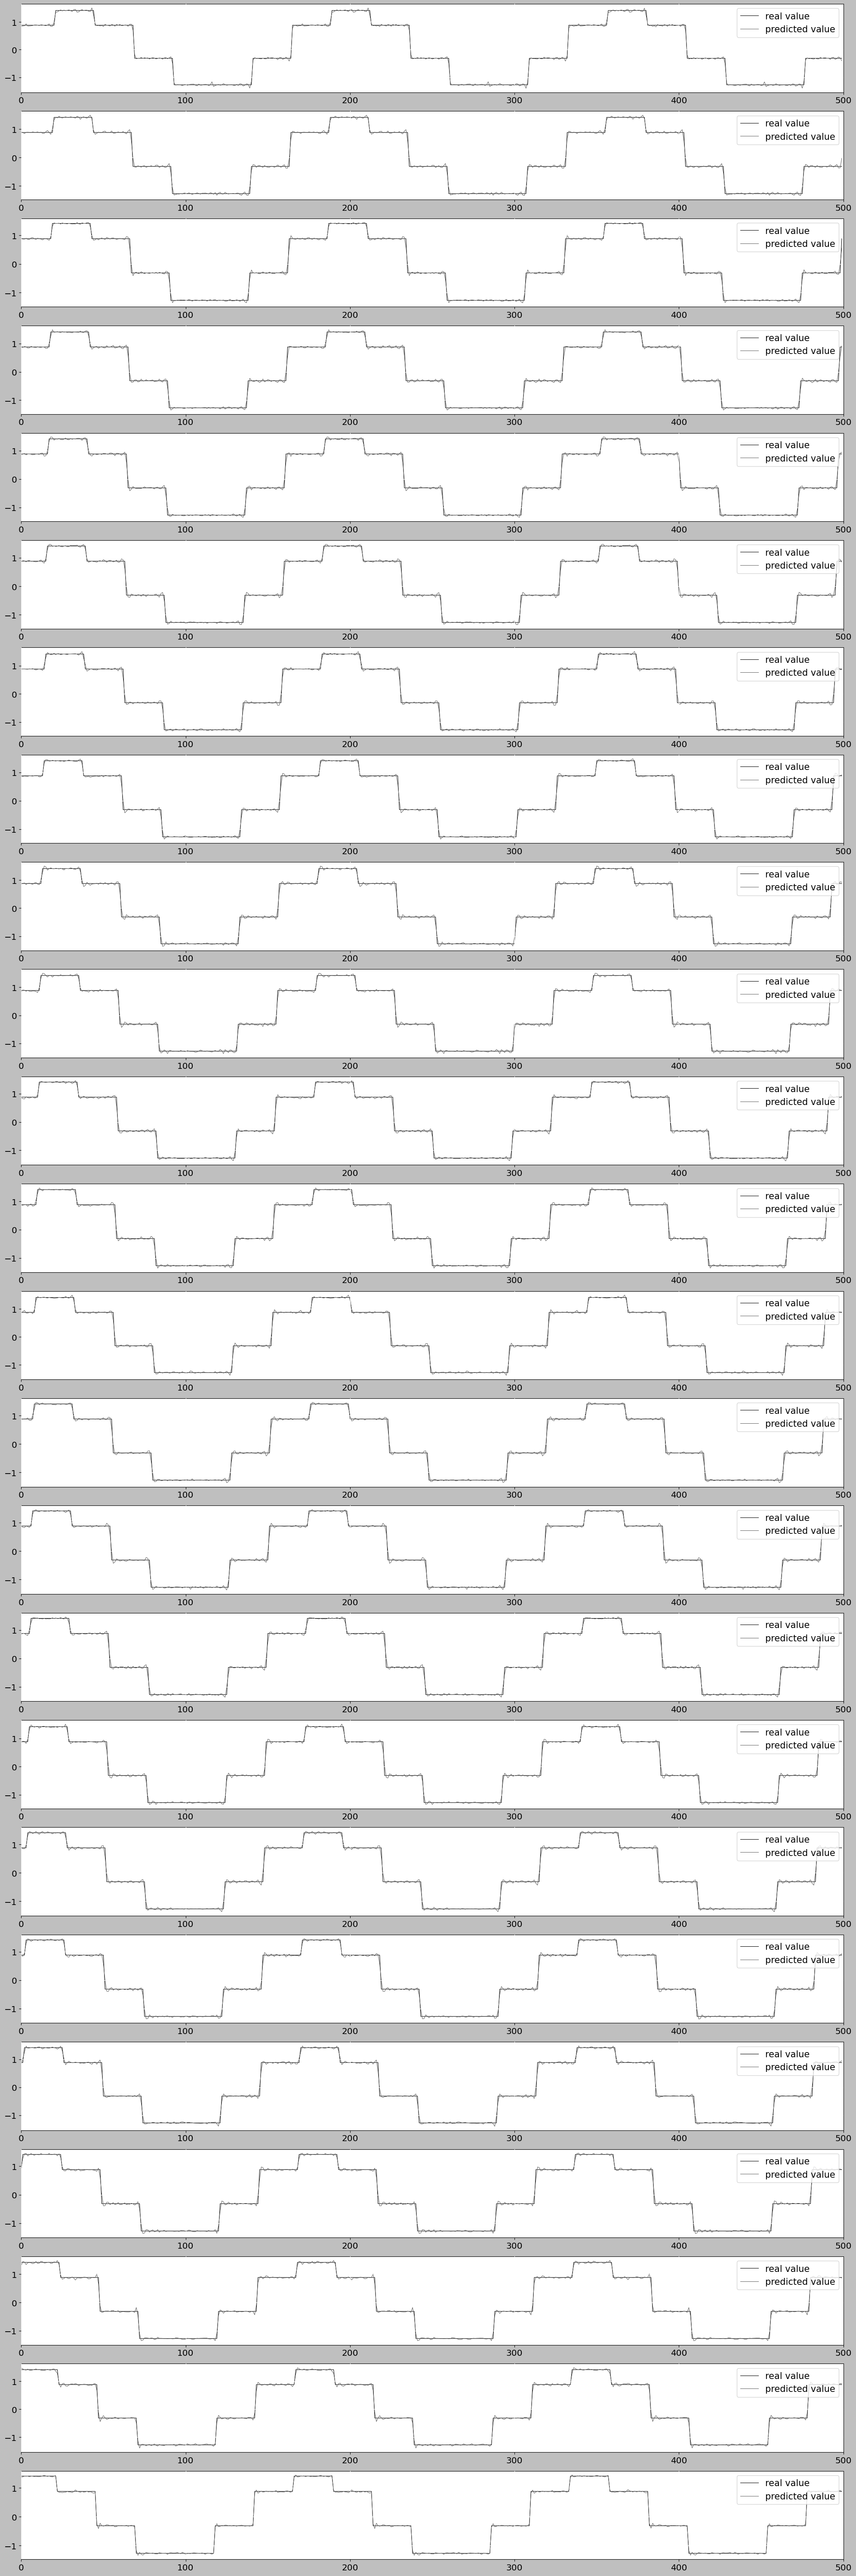

In [87]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(24, 1, figsize=(20, 60))  # Create a figure with 12 subplots
y_predict = model.predict(x_test)
y_predict_array = np.array(y_predict)
# y_predict_array = y_predict_array.reshape(len(y_test), 12)
for i in range(24):
    y_test1 = y_test[:, i]
    y_pre = y_predict_array[:, i]
    # print(y_test1.shape, y_pre.shape)
    draw = pd.concat([pd.DataFrame(y_test[:500, i]), pd.DataFrame(y_pre)], axis=1)
    draw.iloc[:, 0].plot(ax=axs[i])  # Plot y_test value in the corresponding subplot
    draw.iloc[:, 1].plot(ax=axs[i])  # Plot predicted value in the corresponding subplot
    axs[i].legend(('real value', 'predicted value'), loc='upper right', fontsize='15')
    # axs[i].title(f"Test Data vs Predicted after {i+1} hours", fontsize='20')
    axs[i].set_xlim(0, len(y_test1[:]))  # Set the x-axis limits for each subplot

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()


In [88]:
result=pd.read_csv('Results.csv')
result

,Unnamed: 0,TrialNumber,Parameters,learning_rate,MAPE
0,0,1,8-1000-0.5,NaN,0.086571
1,1,2,8-1000-0.1,NaN,0.067750
2,2,3,8-1000-0.05,NaN,0.087781
3,3,4,8-1000-0.01,NaN,0.102972
4,4,5,8-1000-0.005,NaN,0.095018
5,5,6,8-1000-0.001,NaN,0.107783
6,6,7,8-1000-0.0005,NaN,0.070831
7,7,8,8-1000-0.0001,NaN,0.067736
8,8,9,12-1000-0.5,NaN,0.077656
9,9,10,12-1000-0.1,NaN,0.076816


In [89]:
result[['Batch Size', 'Epochs', 'Learning Rate']]=result['Parameters'].str.split('-',expand=True)
evaluate_result=result[['Batch Size','Epochs','Learning Rate','MAPE']]
evaluate_result=evaluate_result.dropna()
evaluate_result

,Batch Size,Epochs,Learning Rate,MAPE
0,8,1000,0.5,0.086571
1,8,1000,0.1,0.067750
2,8,1000,0.05,0.087781
3,8,1000,0.01,0.102972
4,8,1000,0.005,0.095018
5,8,1000,0.001,0.107783
6,8,1000,0.0005,0.070831
7,8,1000,0.0001,0.067736
8,12,1000,0.5,0.077656
9,12,1000,0.1,0.076816


In [90]:
evaluate_result.describe()

,MAPE
count,32.000000
mean,0.083549
std,0.023733
min,0.058352
25%,0.067236
50%,0.076148
75%,0.091613
max,0.155293


In [91]:
print(evaluate_result.min())
print()
print(evaluate_result.max())

Batch Size             12
Epochs               1000
Learning Rate      0.0001
MAPE             0.058352
dtype: object

Batch Size              8
Epochs               1000
Learning Rate         0.5
MAPE             0.155293
dtype: object


In [92]:
print(evaluate_result[evaluate_result.MAPE == evaluate_result.MAPE.min()])
print()
print(evaluate_result[evaluate_result.MAPE == evaluate_result.MAPE.max()])

   Batch Size Epochs Learning Rate      MAPE
28         24   1000         0.005  0.058352

   Batch Size Epochs Learning Rate      MAPE
10         12   1000          0.05  0.155293


In [93]:
# IMPROVED: Apply same feature engineering to prediction data (2017)
dfpredict_data = df_orig.loc['2017', :].copy(deep=True)

# Lag features
dfpredict_data['temp_lag_1h'] = dfpredict_data['Temperature'].shift(1)
dfpredict_data['temp_lag_3h'] = dfpredict_data['Temperature'].shift(3)
dfpredict_data['temp_lag_24h'] = dfpredict_data['Temperature'].shift(24)

# Rolling statistics
dfpredict_data['temp_rolling_mean_6h'] = dfpredict_data['Temperature'].rolling(window=6, min_periods=1).mean()
dfpredict_data['temp_rolling_std_24h'] = dfpredict_data['Temperature'].rolling(window=24, min_periods=1).std()

# Interaction terms
dfpredict_data['temp_humidity_interaction'] = dfpredict_data['Temperature'] * dfpredict_data['Relative Humidity']

# Cyclical encoding
dfpredict_data['hour_sin'] = np.sin(2 * np.pi * dfpredict_data['Hour_of_Day'] / 24)
dfpredict_data['hour_cos'] = np.cos(2 * np.pi * dfpredict_data['Hour_of_Day'] / 24)
dfpredict_data['month_sin'] = np.sin(2 * np.pi * (dfpredict_data['Month'] - 1) / 12)
dfpredict_data['month_cos'] = np.cos(2 * np.pi * (dfpredict_data['Month'] - 1) / 12)
dfpredict_data['day_of_week_sin'] = np.sin(2 * np.pi * dfpredict_data['Day_Of_Week'] / 7)
dfpredict_data['day_of_week_cos'] = np.cos(2 * np.pi * dfpredict_data['Day_Of_Week'] / 7)

# Drop NaN rows
dfpredict_data = dfpredict_data.dropna()

print(f"Prediction data feature engineering complete. Shape: {dfpredict_data.shape}")

Prediction data feature engineering complete. Shape: (8736, 30)


In [94]:
pd.set_option('display.max_columns', 100)

# Select engineered features from prediction data
predict_data = dfpredict_data[[
    # Original weather features
    'Temperature', 'Dewpoint Temp', 'Relative Humidity', 'Wind Speed', 
    'Visibility', 'Pressure',
    # Temporal features
    'Day_of_Year',
    # Engineered features - Lag features
    'temp_lag_1h', 'temp_lag_3h', 'temp_lag_24h',
    # Engineered features - Rolling statistics
    'temp_rolling_mean_6h', 'temp_rolling_std_24h',
    # Engineered features - Interaction terms
    'temp_humidity_interaction',
    # Engineered features - Cyclical encoding
    'hour_sin', 'hour_cos',
    'month_sin', 'month_cos',
    'day_of_week_sin', 'day_of_week_cos'
]]

# FIXED: Use transform (not fit_transform) on prediction data to prevent data leakage
predict = scaler.transform(np.array(predict_data))
print(f"Prediction features shape: {predict.shape}")
predict

Prediction features shape: (8736, 19)


array([[-7.69164223e-01, -2.81702260e-01,  1.79806720e+00, ...,
         1.42193696e+00,  2.86935055e-17,  1.41487582e+00],
       [-7.78361849e-01, -2.81702260e-01,  1.86042872e+00, ...,
         1.42193696e+00,  2.86935055e-17,  1.41487582e+00],
       [-8.24349977e-01, -3.21151840e-01,  1.86042872e+00, ...,
         1.42193696e+00,  2.86935055e-17,  1.41487582e+00],
       ...,
       [-5.20828331e-01, -2.52799901e-02,  1.73570569e+00, ...,
         1.23241985e+00, -1.10578910e+00,  8.82463936e-01],
       [-5.02433080e-01, -5.55520011e-03,  1.73570569e+00, ...,
         1.23241985e+00, -1.10578910e+00,  8.82463936e-01],
       [-4.93235454e-01,  1.41695899e-02,  1.79806720e+00, ...,
         1.23241985e+00, -1.10578910e+00,  8.82463936e-01]],
      shape=(8736, 19))

In [95]:
xp = np.array([np.concatenate((predict[i-2,:], predict[i-1,:], predict[i,:])) for i in range(2, len(predict)-24)])
print(f'xp.shape: {xp.shape}')
yp = np.array([np.stack([predict[i+j+1,-1] for j in range(0, 24)]) for i in range(2, len(predict)-24)])
print(f'yp.shape: {yp.shape}')

xp.shape: (8710, 57)
yp.shape: (8710, 24)


In [96]:
xp.shape
y_prediction = model.predict(xp)
y_prediction_array = np.array(y_prediction)

273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


In [97]:
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

# IMPROVED: Added comprehensive evaluation metrics
mape = mean_absolute_percentage_error(yp, y_prediction)
mae = mean_absolute_error(yp, y_prediction)
mse = mean_squared_error(yp, y_prediction)
rmse = np.sqrt(mse)
r2 = r2_score(yp, y_prediction)

print("=== EVALUATION METRICS ===")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"R² Score: {r2:.6f}")

print(f"\nyp.shape: {yp.shape}")
print(f"y_prediction.shape: {y_prediction.shape}")

# Calculate per-sample MAPE for best/worst analysis
mape_values = []
for actual, predicted in zip(yp, y_prediction):
    mape_values.append(mean_absolute_percentage_error([actual], [predicted]))

worst_mape = np.max(mape_values)
best_mape = np.min(mape_values)

print(f"\nWorst MAPE: {worst_mape:.6f}")
print(f"Best MAPE: {best_mape:.6f}")

# Calculate residuals
residuals = yp - y_prediction
print(f"\nResidual Statistics:")
print(f"Mean Residual: {np.mean(residuals):.6f}")
print(f"Std Residual: {np.std(residuals):.6f}")
print(f"Min Residual: {np.min(residuals):.6f}")
print(f"Max Residual: {np.max(residuals):.6f}")


=== EVALUATION METRICS ===
Mean Absolute Percentage Error (MAPE): 0.062062
Mean Absolute Error (MAE): 0.035328
Mean Squared Error (MSE): 0.004166
Root Mean Squared Error (RMSE): 0.064541
R² Score: 0.995828

yp.shape: (8710, 24)
y_prediction.shape: (8710, 24)

Worst MAPE: 0.143827
Best MAPE: 0.006995

Residual Statistics:
Mean Residual: 0.000284
Std Residual: 0.064540
Min Residual: -0.366714
Max Residual: 0.365748


##VISUALISATION

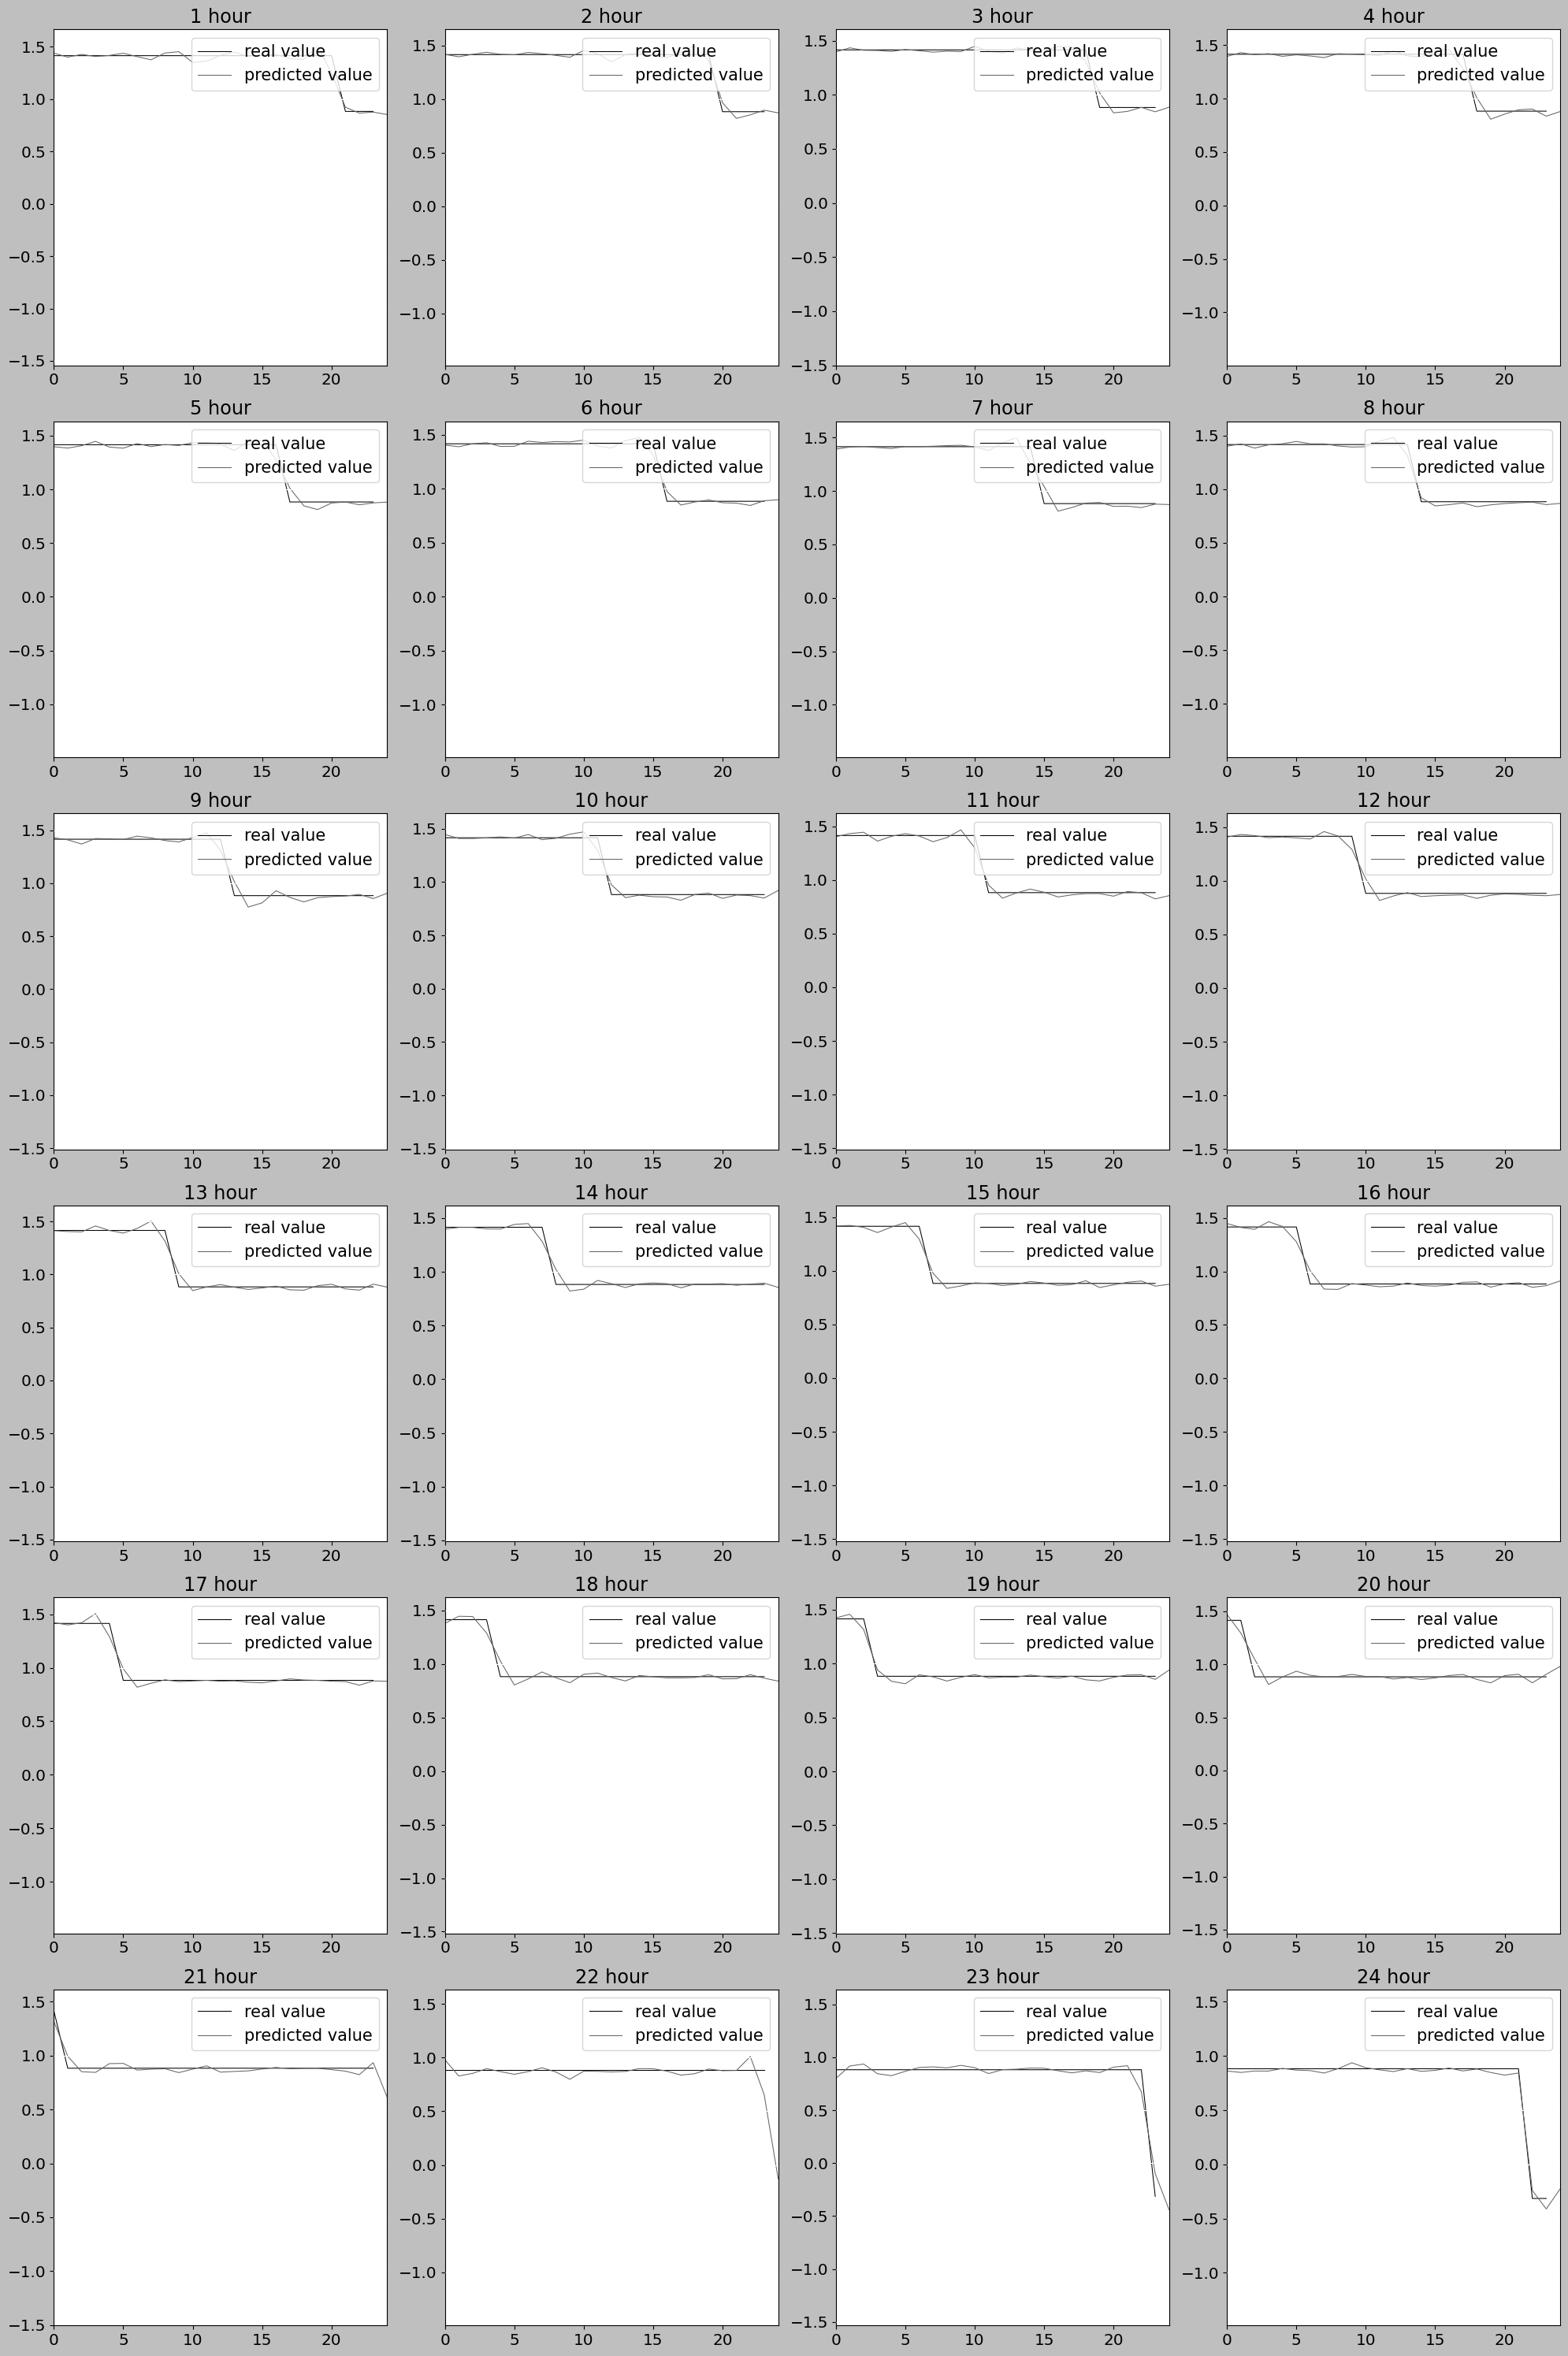

In [98]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(6, 4, figsize=(20, 30))  # Create a figure with 6 rows and 4 columns of subplots


for i in range(24):
    row = i // 4  # Calculate the row index for the subplot
    col = i % 4  # Calculate the column index for the subplot

    y_prede = y_prediction_array[:, i]
    draw = pd.concat([pd.DataFrame(yp[:24, i]), pd.DataFrame(y_prede)], axis=1)

    axs[row, col].plot(draw.iloc[:, 0])  # Plot y_test value in the corresponding subplot
    axs[row, col].plot(draw.iloc[:, 1])  # Plot predicted value in the corresponding subplot
    axs[row, col].legend(('real value', 'predicted value'), loc='upper right', fontsize='15')
    axs[row, col].set_xlim(0, len(yp[:24]))  # Set the x-axis limits for each subplot
    axs[row, col].set_title(f"{i+1} hour")  # Add a title to the subplot indicating the hour

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()


In [99]:
df_predict_aggregate = pd.DataFrame(columns=['prediction_agg', 'actual'])
def aggregate_plot(y_actual, y_pred):
  y_mean_pred = []
  for j in range(23, -1, -1):
    sum=0
    for i in range(0, 24):
      if j-i>=0:
        sum += y_pred[i][j-i]
    y_mean_pred.append(sum/(j+1))
  y_mean_pred = list(reversed(y_mean_pred))
  df_predict_aggregate['prediction_agg'] = y_mean_pred
  df_predict_aggregate['actual'] = y_actual

  mape = mean_absolute_percentage_error(yp, y_prediction)
  print(mape)
  plt.plot(y_actual, marker='*', color='blue')
  plt.plot(y_mean_pred, marker='+', color ='red')
  plt.legend(('real value', 'predicted value'), loc='upper right', fontsize='15')
  plt.show()

In [100]:
df_predict_aggregate

,prediction_agg,actual


0.06206179654500101


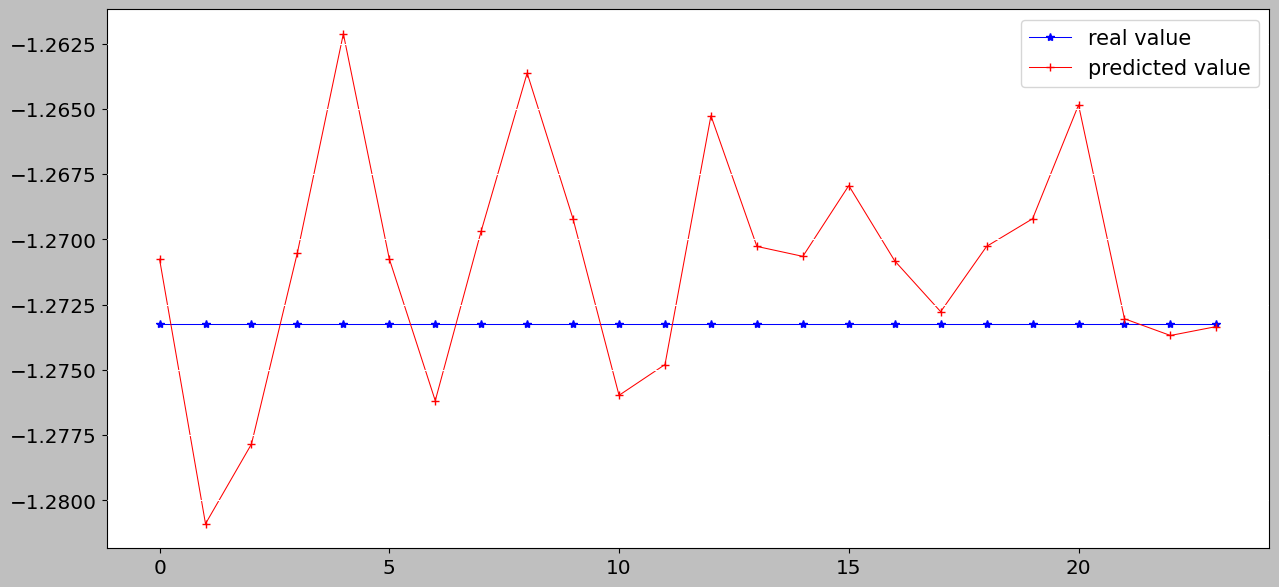

In [101]:
aggregate_plot(yp[240], y_prediction[240:264])